# Tutorial 1 - WaveBot
The goal of this tutorial is to familiarize new users with how to set up and run optimization problems using WecOptTool. 
It uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

At the end of this tutorial the user will perform control co-design of the WEC's geometry and a corresponding optimal controller to maximize electrical power. 
We build up to this problem in three parts of successive complexity:

1. [Optimal control for maximum mechanical power](#1.-Optimal-control-for-maximum-mechanical-power)
2. [Optimal control for maximum electrical power](#2.-Optimal-control-for-maximum-electrical-power)
3. [Control co-design of the WEC's geometry for maximum electrical power](#3.-Control-co-design-of-the-WEC-geometry-for-maximum-electrical-power)

We will start by loading the necessary modules: 

* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 

In [1]:
from datetime import datetime

import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot

## 1. Optimal control for maximum mechanical power
This example illustrates how to set up, run, and analyze a basic optimization problem within WecOptTool.

The objective of this example is to **find the optimal PTO force time-series** that produces the most mechanical power subject to the WEC dynamics and a maximum force the PTO can exert.

WecOptTool requires the following to be defined to successfully run its optimization routines:
- The WEC object, including all of its properties and constraints
- The wave condition
- The objective function

<div>
<img src="https://live.staticflickr.com/65535/52435098523_37d6a2ca94_k.jpg" width="1000">
</div>

The graphic shows all the requirements for this first part of the tutorial: from the wave on the left, to the objective (mechanical power) on the right.
The WEC object, with all it's components, is illustrated in the middle. The components inside the blue box are the WEC properties that are actually passed on to the optimizer.
In short, the WEC's hydrodynamic properties are modelled by
1. Defining the WEC's geometry
2. Meshing the geometry
3. Obtaining the WEC's BEM cofficients based on the mesh
4. Determening the WEC's intrinsic impedance model based on the BEM coefficients

For this first part of the tutorial, the heave-only, WEC-PTO kinematics are trivial (Unity) and the PTO is assumed to be lossless.

### WEC object
In this section we will create the `WEC` object, which contains all the information about the WEC and its dynamics. This constitutes the vast majority of the setup required to run WecOptTool.

Our `WEC` object requires information about the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), any additional dynamic forces (e.g. PTO force, mooring, non-linear hydrodynamics), and constraints (e.g. maximum PTO extension). 
In this case, the only additional force will be the PTO force and the only constraint will be a maximum PTO force of $2,000 N$.

#### Mesh
First, we will create a surface mesh for the hull and store it using the `FloatingBody` object from Capytaine. The WaveBot mesh is pre-defined in the `wecopttool.geom` module, so we will call it directly from there. We will only model the heave degree of freedom in this case. Note that the Capytaine `from_meshio` method can also import from other file types (STL, VTK, MSH, etc.)

In [2]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

At this point we can visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
When running outside a Notebook, these are interactive.  
The included WaveBot example also has a method for plotting the cross-section of the device. 

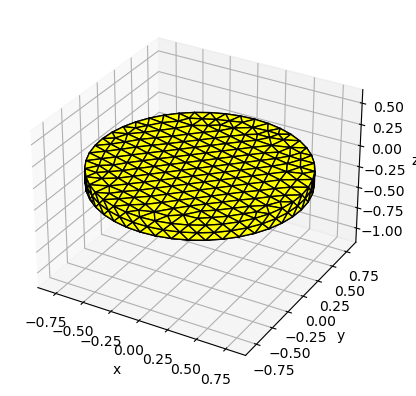

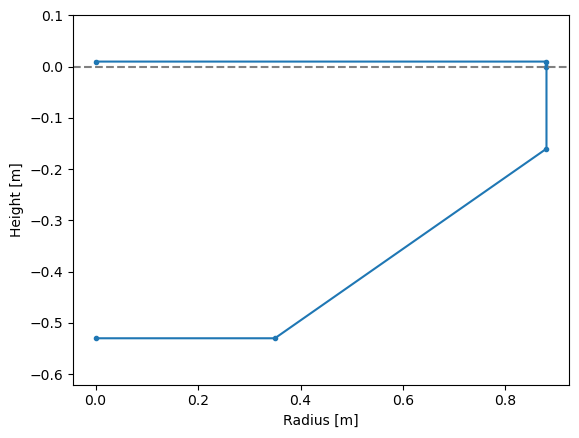

In [3]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True)  # specific to WaveBot

#### Frequency and mesh check
We will analyze 50 frequencies with a spacing of 0.05 Hz. These frequencies will be used for the Fourier representation of both the wave and the desired PTO force in the pseudo-spectral problem. See the Theory section of the Documentation for more details on the pseudo-spectral problem formulation.

The `fb.minimal_computable_wavelength` parameter checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine. This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [4]:
f1 = 2.5/1000
nfreq = 1000
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

min_computable_wavelength = fb.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

#### BEM
With our Capytaine floating body created, we can now run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object. This is wrapped into the `wecopttool.run_bem` function.

If you would like to save our BEM data to a NetCDF file for future use, see the `wecopttool.write_netcdf` function.

In [5]:
bem_data = wot.run_bem(fb, freq)

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.94e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.72e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.15e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.79e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.47e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.14e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.03e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.01e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.09e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.96e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.96e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.95e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.68e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.27e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.82e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.31e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.27e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.93e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.88e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.52e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.19e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.14e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.34e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.31e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.09e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.07e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.84e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.66e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.64e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.63e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.47e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.47e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.45e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.31e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.30e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.14e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.13e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.13e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.12e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.98e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.86e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.85e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.72e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.72e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.70e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.59e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.59e-01.
This warning appears because the largest panel 

#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC. Data wrapped into our `PTO` class will be used to help define our `WEC` object and optimization problem later.

To create an instance of the `PTO` class, we need:
- The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom. The PTO extracts power directly from the WEC's heave in this case, so the kinematics matrix is simply the $1 \times 1$ identity matrix.
- The definition of the PTO controller. The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force. However, we will be using an unstructured controller in this case, so we will set `None` for the controller.
- Any PTO impedance. We're only interested in mechanical power for this first problem, so we will leave this empty for now
- The non-linear power conversion loss (assumed 0% if `None`)
- The PTO system name, if desired

In [6]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None #wot.pto.controller_pi
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now let's define the PTO forcing on the WEC and the PTO constraints. For our optimization problem, the constraints must be in the correct format for `scipy.optimize.minimize()`. We will enforce the constraint at 4 times more points than the dynamics (see Theory for why this is helpful for the pseudo-spectral problem).

In [7]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 200
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

#### `WEC` creation
We are now ready to create the `WEC` object itself! Since we ran our BEM already, we can define the object using the `wecopttool.WEC.from_bem` function. If we saved our BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [8]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

Note: We might receive a warning regarding negative linear damping values. Per default, WecOptTool ensures that the BEM data does not contain non-negative damping values. If you would like to correct the BEM solution manually to a minimum damping value you can specify `min_damping`. 

### Waves
The wave environment must be specified as a 2-dimensional `xarray.DataArray` containing the complex amplitude (m). 
The two coordinates are the radial frequency ``omega`` (rad/s)  and the direction ``wave_direction`` (rad). 
The `wecopttool.waves` submodule contains functions for creating this `xarray.DataArray` for different types of wave environments. 

In this case we will use a regular wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m. 
We will use the `wecopttool.waves.regular_wave` function. 

In [9]:
amplitude = 0.0625  
wavefreq = 0.3
phase = 30
wavedir = 0
waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

# irregular
Hs = .4
Tp = 2
nrealizations = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)

### Objective function
The objective function is the quantity (scalar) we want to optimize—in this case, the average mechanical power. The objective function is itself a function of the optimization state, the size of which we need to properly define our call to `scipy.optimize.minimize()`. The average mechanical power can be taken directly from the `PTO` object we created.

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients. This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave). Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero. Excluding this component speeds up the optimization as the state space is reduced by one.

In [10]:
obj_fun = pto.average_power
nstate_opt = 2*nfreq

### Solve
We are now ready to solve the problem. WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

Note that the only required inputs for defining and solving the problem are: (1) the waves, (2) the objective function, and (3) the size of the optimization state. Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance. See `scipy.optimize.minimize` docs for more details.

To help the optimization we will scale the problem before solving it (see Documentation). WecOptTool allows you to scale the WEC dynamics state, your optimization state (in this case the Fourier coefficients for the PTO force), and the objective function separately. See the `wecopttool.WEC.solve()` function for more information.


Pay attention to the `Exit mode`: an exit mode of $0$ indicates a successful solution. For an easy problem (linear, single Dof, unconstrained, etc.) your iterations shouldn't need to exceed 100. If they do, try adjusting the scales by orders of magnitude, one at a time.

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

options = {'maxiter': 400}
scale_x_wec = 1e2
scale_x_opt = 1e-2
scale_obj = 1e-1

results = wec.solve(
    waves_irregular, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+01, 8.26e+01, 3.25e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+01, 8.26e+01, 3.25e+04]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+00, 5.18e-01, 2.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.51e+00, 5.18e-01, 2.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.17e+00, 2.02e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.17e+00, 2.02e-01, -1.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+00, 2.35e-01, -2.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.08e+00, 2.35e-01, -2.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0932668160229766
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 1.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 1.

KeyboardInterrupt



### Analyzing results
We will use two post-processing functions to obtain frequency- and time-domain results for the WEC and PTO responses. The pseudospectral method gives continuous in time results. To get smoother looking plots, we specify the number of subpoints betweeen co-location points. In this case we will use 5. 

In [109]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results[0], waves.sel(realization=0), nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(results[0], waves.sel(realization=0), nsubsteps=nsubsteps)

The `pto.post_process` function returns `xarray.Dataset`s, which have built-in integration with PyPlot for smart plotting that automagically sets titles and formatting. We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

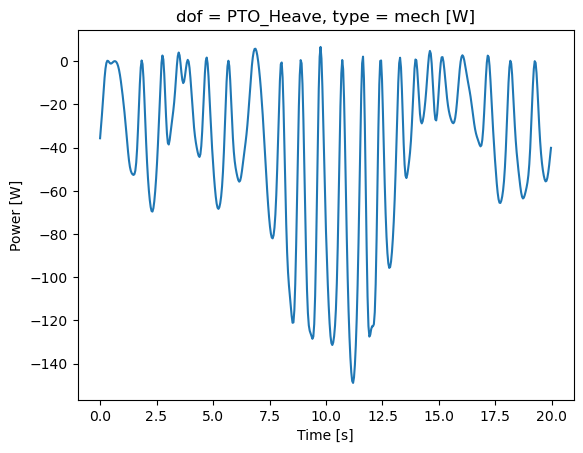

In [110]:
plt.figure()
pto_tdom['power'].loc['mech',:,:].plot()

We could similarly plot any time- or frequency-domain repsonse of the WEC or PTO. For instance, here is the PTO heave motion.

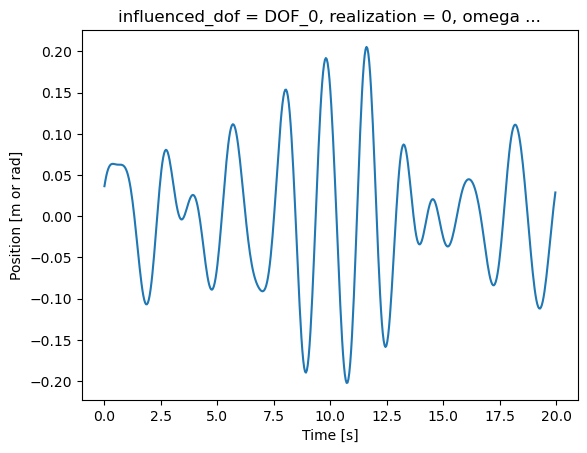

In [111]:
plt.figure()
wec_tdom['pos'].plot()

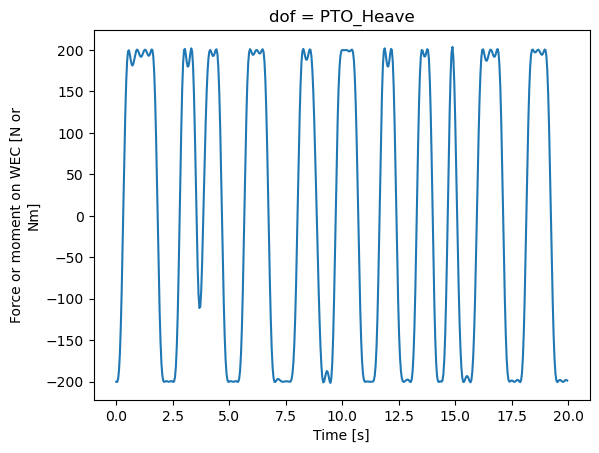

In [112]:
plt.figure()
pto_tdom['force'].plot()

Text(0.5, 0, 'frequency [rad/s]')

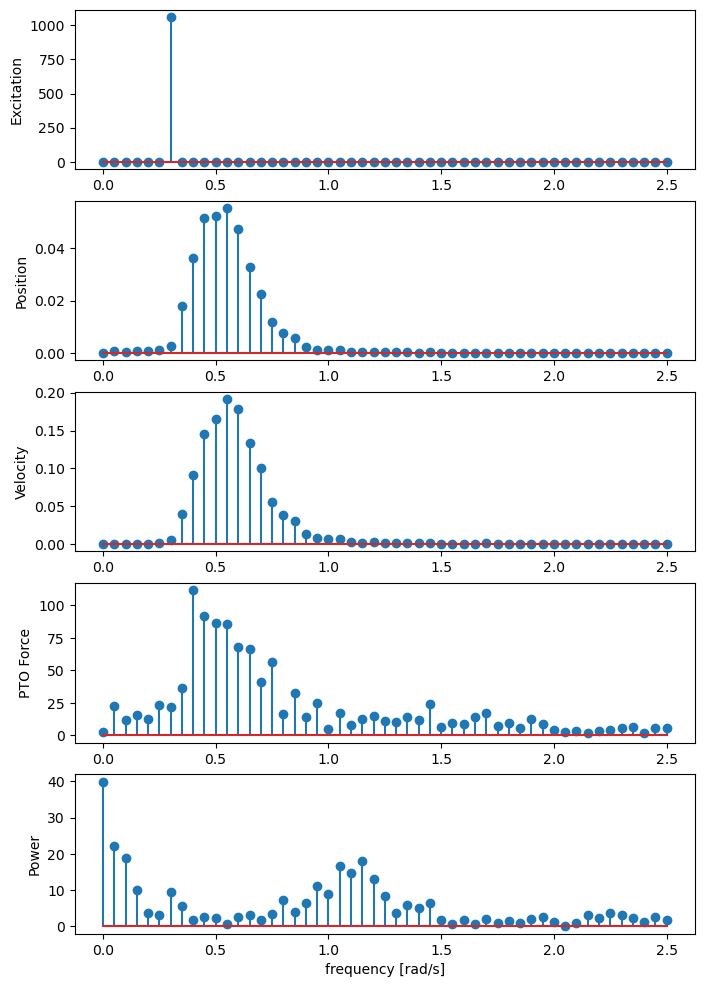

In [113]:
excitation_force = wec_fdom['force'].sel(type='Froude_Krylov') + wec_fdom['force'].sel(type='diffraction')
position = wec_fdom.pos
velocity = wec_fdom.vel
pto_force =  pto_fdom.force
mech_power = pto_fdom.power.sel(type = 'mech')
power = pto_fdom.power.sel(type = 'elec')

fig, ax = plt.subplots(5,1,figsize=(8, 12))

ax[0].stem(wec_fdom['freq'],abs(excitation_force))
ax[0].set_ylabel('Excitation')

ax[1].stem(wec_fdom['freq'],abs(position))
ax[1].set_ylabel('Position')

ax[2].stem(wec_fdom['freq'],abs(velocity))
ax[2].set_ylabel('Velocity')

# Plot PTO force
ax[3].stem(wec_fdom['freq'],abs(pto_force))
ax[3].set_ylabel('PTO Force')

# Plot power
#ax[5].stem(omegas,abs(mech_power))
ax[4].stem(wec_fdom['freq'],abs(power))
ax[4].set_ylabel('Power')
ax[4].set_xlabel('frequency [rad/s]')

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`). For example, the time domain PTO variable contains the following response:

In [74]:
pto_fdom

<xarray.Dataset>
Dimensions:  (omega: 301, dof: 1, type: 2)
Coordinates:
  * omega    (omega) float64 0.0 0.05236 0.1047 0.1571 ... 15.6 15.66 15.71
    freq     (omega) float64 0.0 0.008333 0.01667 0.025 ... 2.483 2.492 2.5
    period   (omega) float64 inf 120.0 60.0 40.0 ... 0.404 0.4027 0.4013 0.4
  * dof      (dof) <U9 'PTO_Heave'
  * type     (type) <U4 'mech' 'elec'
Data variables:
    pos      (omega, dof) complex128 (0.00015261605473468944+0j) ... (-8.6472...
    vel      (omega, dof) complex128 (8.548717289613706e-17+0j) ... (1.369275...
    acc      (omega, dof) complex128 (-8.363680118842847e-16+0j) ... (0.00021...
    force    (omega, dof) complex128 (3.722767425156228+0j) ... (0.3115559300...
    power    (type, omega, dof) complex128 (-33.85783032382827+0j) ... (0.413...
Attributes:
    time_created_utc:  2023-12-01 16:07:16.359659

## 2. Optimal control for maximum electrical power

The rest of this tutorial will focus on optimizing for electrical power (new objective function) rather than mechanical, as this is a form of power that is usable and transportable.

Since we're still dealing with the same WaveBot as in part 1, we can reuse the BEM and wave data from before. Look back at part 1 if you need a refresher on how to create these data.

<div>
<img src="https://live.staticflickr.com/65535/52435033525_b8efc28d16_k.jpg" width="1000">
</div>
The WEC-PTO kinematics remain the same as well (unity). The major difference now is that we consider the dynamics of PTO, since they impact the electrical power and we shall not assume a lossless PTO.

We will express the PTO's dynamics in form of a 2-port impedance model, to incoporate the dynamics of the drive-train and the dynamics of the generator.
The additional mechanical energy storage through the drive-train is modelled using Newton's second law and we assume a linear generator using a power-invariant park transform.

The PTO impedance matrix components are then obtained under open-circuit  conditions, i.e.  no  load  current  or  no  WEC  velocity,  respectively.

The attentive user might have noticed that the amplitude of the position, force and power signals is about half the magnitude of the signals we plotted in the first part of the tutorial. We can see that optimizing for electrical power requires optimal state trajectories with smaller amplitudes. For most WECs the electrical power is the usable form of power, thus the WEC should be designed for electrical power and we can avoid over-designing, which would results from expecting the forces associated with the optimal trajectories for mechanical power maximisation.

## 3. Control co-design of the WEC geometry for maximum electrical power
The first two examples only used the inner optimization loop in WecOptTool to optimize PTO power. Here in Part 3 we bring it all together and show how to use both the inner and outer optimization loops in WecOptTool to do control co-optimization of a hull design in conjunction with an optimal controller for electrical power.
Again, we use the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average produced electrical power, while maintaining a constant hull volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geometry (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in Example 2 and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg) 
<div>
<img src="https://live.staticflickr.com/65535/52434071157_187eb4334c_k.jpg" width="1000">
</div>



### Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Part 2 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

Note that in this case the magnitude of average power between the different keel radii is rather small, this is because the PTO force constraint is active most of the time, therefore all considered geometries perform similarily. If you remove the PTO constraint and re-run the co-optimization study you will see that the impact of radius on average electrical power is significantly higher.

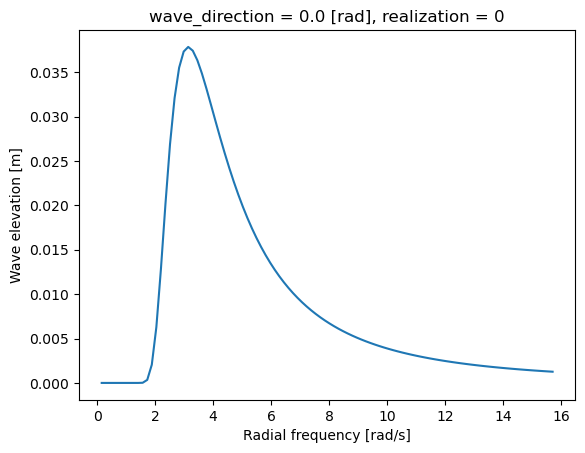

In [38]:
# irregular
Hs = .4
Tp = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")

meanpower = []

waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 400)

fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

In [91]:
# calculate max power
Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
ampSpect = waves_irregular.sel(realization=0).values
Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

hydro_data = wot.add_linear_friction(bem_data)
Zi = wot.hydrodynamic_impedance(hydro_data)

# Maximum Mechanical Power
P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
P_ub = - sum(np.squeeze(P_ub_vec)).values

print(f'Max Theoretical Power: {P_ub}')

Max Theoretical Power: -120.9305908237039


In [92]:
results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt=2,#*nfreq,
    optim_options=options,
    scale_x_wec=5e1,
    scale_x_opt=1.2e-4,
    scale_obj=1.2e-2,
)

power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641958252
            Iterations: 80
            Function evaluations: 109
            Gradient evaluations: 80
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641943122
            Iterations: 95
            Function evaluations: 137
            Gradient evaluations: 95
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934362
            Iterations: 118
            Function evaluations: 170
            Gradient evaluations: 118
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641928425
            Iterations: 206
            Function evaluations: 459
            Gradient evaluations: 206
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934276
            Iterations: 96
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7251466829030678
            Iterations: 174
            Function evaluations: 636
            Gradient evaluations: 174
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934307
            Iterations: 113
            Function evaluations: 162
            Gradient evaluations: 113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641943206
            Iterations: 126
            Function evaluations: 179
            Gradient evaluations: 126
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641973271
            Iterations: 144
            Function evaluations: 230
            Gradient evaluations: 144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934784
            Iterations: 140
      

Iteration limit reached    (Exit mode 9)
            Current function value: -1.1692553559508865
            Iterations: 400
            Function evaluations: 1252
            Gradient evaluations: 400
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641933667
            Iterations: 115
            Function evaluations: 153
            Gradient evaluations: 115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641882961
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364209888
            Iterations: 133
            Function evaluations: 206
            Gradient evaluations: 133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934325
            Iterations: 123
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934302
            Iterations: 56
            Function evaluations: 59
            Gradient evaluations: 56
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641839127
            Iterations: 124
            Function evaluations: 168
            Gradient evaluations: 124
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934078
            Iterations: 86
            Function evaluations: 119
            Gradient evaluations: 86
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641933423
            Iterations: 103
            Function evaluations: 142
            Gradient evaluations: 103
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934385
            Iterations: 126
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553642075225
            Iterations: 43
            Function evaluations: 47
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641933794
            Iterations: 104
            Function evaluations: 140
            Gradient evaluations: 104
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364193988
            Iterations: 132
            Function evaluations: 194
            Gradient evaluations: 132
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641935275
            Iterations: 121
            Function evaluations: 161
            Gradient evaluations: 121
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364193433
            Iterations: 125
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641938803
            Iterations: 228
            Function evaluations: 536
            Gradient evaluations: 228
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934313
            Iterations: 101
            Function evaluations: 133
            Gradient evaluations: 101
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641932937
            Iterations: 118
            Function evaluations: 168
            Gradient evaluations: 118
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641928825
            Iterations: 102
            Function evaluations: 137
            Gradient evaluations: 102
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641935715
            Iterations: 127
      

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641891485
            Iterations: 111
            Function evaluations: 156
            Gradient evaluations: 111
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641935026
            Iterations: 96
            Function evaluations: 112
            Gradient evaluations: 96
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641892776
            Iterations: 124
            Function evaluations: 164
            Gradient evaluations: 124
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553642082566
            Iterations: 122
            Function evaluations: 168
            Gradient evaluations: 122


Iteration limit reached    (Exit mode 9)
            Current function value: 1802218384.140991
            Iterations: 400
            Function evaluations: 1056
            Gradient evaluations: 400
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641947536
            Iterations: 124
            Function evaluations: 175
            Gradient evaluations: 124
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641932049
            Iterations: 114
            Function evaluations: 159
            Gradient evaluations: 114
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1561226323338305
            Iterations: 212
            Function evaluations: 573
            Gradient evaluations: 212
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641995556
            Iterations: 108
            Function

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641940844
            Iterations: 122
            Function evaluations: 172
            Gradient evaluations: 122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641933878
            Iterations: 86
            Function evaluations: 114
            Gradient evaluations: 86
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364206491
            Iterations: 122
            Function evaluations: 162
            Gradient evaluations: 122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364193413
            Iterations: 119
            Function evaluations: 178
            Gradient evaluations: 119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692102809011946
            Iterations: 141
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364208318
            Iterations: 128
            Function evaluations: 187
            Gradient evaluations: 128
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553642095147
            Iterations: 134
            Function evaluations: 205
            Gradient evaluations: 134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934285
            Iterations: 116
            Function evaluations: 151
            Gradient evaluations: 116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641933823
            Iterations: 122
            Function evaluations: 168
            Gradient evaluations: 122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641987484
            Iterations: 115
       

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641944883
            Iterations: 113
            Function evaluations: 130
            Gradient evaluations: 113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641997885
            Iterations: 112
            Function evaluations: 150
            Gradient evaluations: 112
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641624392
            Iterations: 148
            Function evaluations: 232
            Gradient evaluations: 148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934393
            Iterations: 113
            Function evaluations: 156
            Gradient evaluations: 113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641934158
            Iterations: 132
      

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641930248
            Iterations: 101
            Function evaluations: 137
            Gradient evaluations: 101
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.169255364190304
            Iterations: 109
            Function evaluations: 147
            Gradient evaluations: 109
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641914867
            Iterations: 45
            Function evaluations: 46
            Gradient evaluations: 45
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641891827
            Iterations: 215
            Function evaluations: 447
            Gradient evaluations: 215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1692553641930592
            Iterations: 82
           

In [24]:
import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],power_results),x=(['ind','ind2'],x_results)), 
                    coords=dict(ind=range(len(power_results)),ind2=range(len(x_results[0]))))
res_ds.to_netcdf('wavebot_power_convergence_025_lin.nc')

In [27]:
# load results
import xarray as xr
res_ds = xr.load_dataset('wavebot_power_convergence_025_lin.nc')

(-91.78, -91.77)

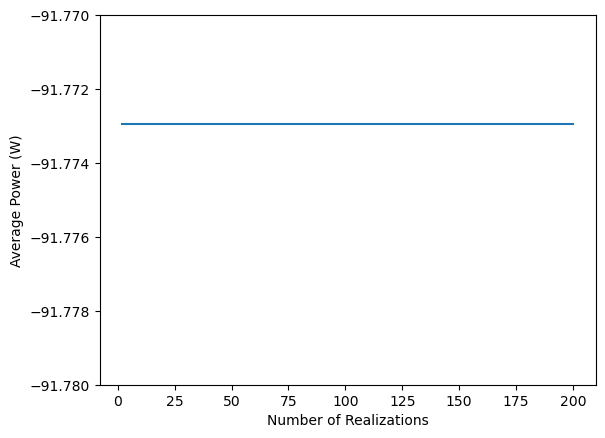

In [35]:
rolling_mean = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')
#plt.xlim([200, 400])
plt.ylim([-91.78,-91.77])

Text(0.5, 0, 'Number of Realizations')

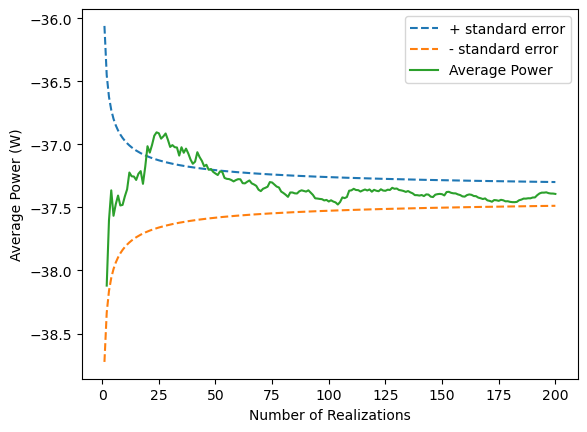

In [19]:
rolling_sem = []
rolling_var = []

stdev = np.std(res_ds['power'])

for ind in range(len(res_ds['power'])):
    
    #stdev = np.std(res_ds['power'][0:ind])
    
    rolling_var.append(stdev**2)
    
    rolling_sem.append(stdev/np.sqrt(ind+1))
    
rolling_sem_pos = [sum(x) for x in zip(rolling_sem, rolling_mean)]
rolling_sem_neg = [y-x for x, y in zip(rolling_sem, rolling_mean)]

rolling_sem_pos = [sum(x,rolling_mean[-1]) for x in zip(rolling_sem)]
rolling_sem_neg = [rolling_mean[-1]-x for x in rolling_sem]

rolling_var_pos = [sum(x) for x in zip(rolling_var, rolling_mean)]
rolling_var_neg = [y-x for x, y in zip(rolling_var, rolling_mean)]
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_sem_pos,'--',label='+ standard error')
plt.plot(range(1,len(res_ds['power'])+1),rolling_sem_neg,'--',label='- standard error')
#plt.plot(range(1,len(res_ds['power'])+1),rolling_var_pos)
#plt.plot(range(1,len(res_ds['power'])+1),rolling_var_neg)
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean,label='Average Power')
plt.legend()
plt.ylabel('Average Power (W)')
plt.xlabel('Number of Realizations')

Text(0, 0.5, 'Integral Gain')

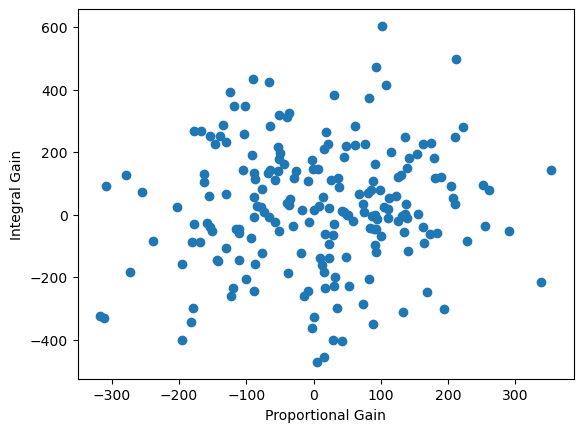

In [124]:
x_opts = []

for x in res_ds['x']:
    x_wec, x_opt = wec.decompose_state(x)
    x_opts.append(x_opt.to_numpy())

x_opts = np.array(x_opts)

x_diff = x_opts[-1] - x_opts[0]
#print(x_opts)

plt.figure() 
plt.scatter(-x_opts[:,0],-x_opts[:,1])
plt.xlabel('Proportional Gain')
plt.ylabel('Integral Gain')

In [125]:
# Now, calculate the mean P and I gains and plug them back into each of the realizations to see the total average power

# calculate mean P and I gains
mean_p = np.mean(x_opts[:,0])
print(mean_p)
mean_i = np.mean(x_opts[:,1])
print(mean_i)

# set equality constraints on the P and I gains
constraints = []

bounds = ((mean_p,mean_p),(mean_i,mean_i))

# Create WEC
wec = wot.WEC.from_bem(bem_data,
        constraints=constraints,
        friction=None, 
        f_add=f_add,
        )

results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt=2,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
    bounds_opt=bounds,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


-7.761511708951394
-23.994186682442873


ValueError: shapes (200,200) and (2,1) not aligned: 200 (dim 1) != 2 (dim 0)

In [ ]:
rolling_mean_const_PI = []

for ind in range(len(res_ds['power'])):

    rolling_mean_const_PI.append(np.mean(power_results[0:ind]))

plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean, label = 'variable PI gains')
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean_const_PI, label = 'mean PI gains')
plt.legend()
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [ ]:
wf1, wt1 = wec.post_process(results[0], waves_irregular.sel(realization=0), nsubsteps)
pf1, pt1 = pto.post_process(wec, results[0], waves_irregular.sel(realization=0), nsubsteps)

wf2, wt2 = wec.post_process(results[1], waves_irregular.sel(realization=1), nsubsteps)
pf2, pt2 = pto.post_process(wec, results[1], waves_irregular.sel(realization=1), nsubsteps)

plt.figure()
pt1['force'].plot()

plt.figure()
pt2['force'].plot()

consResults = []

for ind, result in enumerate(results):
    wf, wt = wec.post_process(result, waves_irregular.sel(realization=ind), nsubsteps)
    pf, pt = pto.post_process(wec, result, waves_irregular.sel(realization=ind), nsubsteps)
    consResults.append(np.any(abs(pt['force']) > f_max))
    print(ind)

print(sum(consResults))
print(400-sum(consResults))

In [ ]:
# load results
import xarray as xr
res_ds = xr.load_dataset('LUPA_power_convergence.nc')

In [ ]:
print(res_ds)

In [ ]:
rolling_mean = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [ ]:
# load results
import xarray as xr
res_ds = xr.load_dataset('pioneer_power_convergence.nc')

In [ ]:
rolling_mean = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [42]:
import time
import logging
logging.basicConfig(level=logging.INFO)

# compare run times vs. number of frequencies
nfreqs = np.linspace(20,100,9)
fend = 2.5

runtime = []
meanpower = []
Pmaxs = []

name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 200
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = []

# irregular
Hs = .4
Tp = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

nrealizations = 20

scale_x_wec=1e2
scale_x_opt=1e-2
scale_obj=1e-1
options = {'maxiter': 400}

# run each simulation for 20 minutes

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)

    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)
    
    print(f'nfreq: {nfreq}')
    starttime = time.time()
    
    results = wec.solve(
        waves_irregular,
        obj_fun,
        nstate_opt=2*int(nfreq),
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )
    
    power_results = [result.fun for result in results]
    x_results = [result.x for result in results]
    print(f'Optimal average power: {np.mean(power_results):.2f} W')
    
    meanpower.append(np.mean(power_results))
    
    endtime = time.time()
    runtime.append(endtime-starttime)
    print(runtime)
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.571, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.571, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.356, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.352, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.352, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.137, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 20.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.20e+00, 9.31e-01, 1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.20e+00, 9.31e-01, 1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.29e+00, 1.06e+00, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.29e+00, 1.06e+00, -1.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.30e+00, 1.49e+00, -4.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.30e+00, 1.49e+00, -4.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+00, 1.42e+00, -4.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+00, 1.42e+00, -4.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+00, 1.39e+00, -4.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+00, 1.39e+00, -4.28e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.2880314692323935
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.08e+00, 1.01e+00, 7.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.08e+00, 1.01e+00, 7.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.37e+00, 1.06e+00, -1.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.37e+00, 1.06e+00, -1.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.53e+00, 1.31e+00, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.53e+00, 1.31e+00, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.55e+00, 1.26e+00, -3.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.55e+00, 1.26e+00, -3.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+00, 1.23e+00, -3.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+00, 1.23e+00, -3.94e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.017842559252237
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.02e+00, 9.43e-01, 3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.02e+00, 9.43e-01, 3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+00, 6.90e-01, 2.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+00, 6.90e-01, 2.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.72e+00, 1.65e+00, -4.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.72e+00, 1.65e+00, -4.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.69e+00, 1.39e+00, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.69e+00, 1.39e+00, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.58e+00, 1.48e+00, -3.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.58e+00, 1.48e+00, -3.95e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.029274049715667
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.80e+00, 9.77e-01, -3.76e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.80e+00, 9.77e-01, -3.76e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.94e+00, 1.04e+00, -2.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.94e+00, 1.04e+00, -2.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.68e+00, 1.64e+00, -4.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.68e+00, 1.64e+00, -4.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.69e+00, 1.65e+00, -4.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.69e+00, 1.65e+00, -4.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+00, 1.62e+00, -4.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.75e+00, 1.62e+00, -4.32e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.350000660798732
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.27e+00, 9.47e-01, 4.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.27e+00, 9.47e-01, 4.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.52e+00, 5.71e-01, 5.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.52e+00, 5.71e-01, 5.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.18e+00, 1.18e+00, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.18e+00, 1.18e+00, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+00, 1.49e+00, -4.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+00, 1.49e+00, -4.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.74e+00, 1.55e+00, -4.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.74e+00, 1.55e+00, -4.18e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.241487014776914
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.88e+00, 1.02e+00, -2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.88e+00, 1.02e+00, -2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.02e+00, 1.11e+00, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.02e+00, 1.11e+00, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.18e+00, 1.45e+00, -3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.18e+00, 1.45e+00, -3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.19e+00, 1.51e+00, -3.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.19e+00, 1.51e+00, -3.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.23e+00, 1.57e+00, -3.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.23e+00, 1.57e+00, -3.91e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9516949644544215
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.36e+00, 1.00e+00, 2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.36e+00, 1.00e+00, 2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.38e+00, 7.77e-01, 9.90e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.38e+00, 7.77e-01, 9.90e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.41e+00, 8.48e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.41e+00, 8.48e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.67e+00, 1.15e+00, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.67e+00, 1.15e+00, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.87e+00, 1.40e+00, -3.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.87e+00, 1.40e+00, -3.85e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9751023070086497
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.47e+00, 9.39e-01, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.47e+00, 9.39e-01, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.43e+00, 9.84e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.43e+00, 9.84e-01, -2.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.38e+00, 1.54e+00, -3.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.38e+00, 1.54e+00, -3.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.44e+00, 1.59e+00, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.44e+00, 1.59e+00, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.48e+00, 1.60e+00, -3.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.48e+00, 1.60e+00, -3.76e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.856312191312617
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.83e+00, 9.78e-01, 1.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.83e+00, 9.78e-01, 1.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.18e+00, 1.18e+00, -1.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.18e+00, 1.18e+00, -1.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.05e+00, 1.66e+00, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.05e+00, 1.66e+00, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.99e+00, 1.75e+00, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.99e+00, 1.75e+00, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.91e+00, 1.80e+00, -3.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.91e+00, 1.80e+00, -3.79e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.877943795081472
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.74e+00, 8.62e-01, 1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.74e+00, 8.62e-01, 1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.25e+00, 1.12e+00, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.25e+00, 1.12e+00, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.85e+00, 1.66e+00, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.85e+00, 1.66e+00, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.87e+00, 1.66e+00, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.87e+00, 1.66e+00, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.89e+00, 1.63e+00, -3.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.89e+00, 1.63e+00, -3.92e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9673513644988563
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.29e+00, 9.10e-01, 4.31e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.29e+00, 9.10e-01, 4.31e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.65e+00, 1.04e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.65e+00, 1.04e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.68e+00, 1.68e+00, -4.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.68e+00, 1.68e+00, -4.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.55e+00, 1.67e+00, -4.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.55e+00, 1.67e+00, -4.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.49e+00, 1.66e+00, -4.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.49e+00, 1.66e+00, -4.31e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.353646939852615
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.98e+00, 1.00e+00, -1.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.98e+00, 1.00e+00, -1.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.68e+00, 1.04e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.68e+00, 1.04e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.15e+00, 1.45e+00, -4.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.15e+00, 1.45e+00, -4.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 1.47e+00, -4.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 1.47e+00, -4.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 1.53e+00, -4.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 1.53e+00, -4.34e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.343400766651812
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+00, 1.02e+00, -1.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+00, 1.02e+00, -1.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.10e+00, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.10e+00, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+00, 1.33e+00, -3.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+00, 1.33e+00, -3.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.77e+00, 1.38e+00, -4.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.77e+00, 1.38e+00, -4.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+00, 1.40e+00, -4.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.84e+00, 1.40e+00, -4.07e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.138967288355476
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.85e+00, 1.07e+00, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.85e+00, 1.07e+00, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.35e+00, 1.09e+00, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.35e+00, 1.09e+00, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.48e+00, 1.11e+00, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.48e+00, 1.11e+00, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.98e+00, 1.27e+00, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.98e+00, 1.27e+00, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.80e+00, 1.31e+00, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.80e+00, 1.31e+00, -3.52e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6553983776401915
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.93e+00, 1.02e+00, -3.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.93e+00, 1.02e+00, -3.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.65e+00, 1.03e+00, -1.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.65e+00, 1.03e+00, -1.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.09e+00, 1.21e+00, -3.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.09e+00, 1.21e+00, -3.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.99e+00, 1.20e+00, -4.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.99e+00, 1.20e+00, -4.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.94e+00, 1.25e+00, -4.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.94e+00, 1.25e+00, -4.10e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.183179552225634
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.96e+00, 9.74e-01, 9.30e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.96e+00, 9.74e-01, 9.30e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.32e+00, 1.10e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.32e+00, 1.10e+00, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.12e+00, 1.88e+00, -4.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.12e+00, 1.88e+00, -4.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.17e+00, 1.90e+00, -4.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.17e+00, 1.90e+00, -4.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.25e+00, 1.87e+00, -4.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.25e+00, 1.87e+00, -4.30e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.342031199896886
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.03e+01, 1.09e+00, 2.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.03e+01, 1.09e+00, 2.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.77e+00, 9.90e-01, -3.04e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.77e+00, 9.90e-01, -3.04e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.71e+00, -4.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.71e+00, -4.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.61e+00, -4.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.61e+00, -4.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.20e+00, 1.65e+00, -4.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.20e+00, 1.65e+00, -4.28e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.354102441942685
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.71e+00, 1.07e+00, -7.70e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.71e+00, 1.07e+00, -7.70e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.31e+00, 1.02e+00, -1.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.31e+00, 1.02e+00, -1.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.73e+00, 1.52e+00, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.73e+00, 1.52e+00, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.40e+00, 1.63e+00, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.40e+00, 1.63e+00, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.11e+00, 1.68e+00, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.11e+00, 1.68e+00, -3.63e+00]
INFO:wecopttool.core

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7312742393153764
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.61e+00, 9.01e-01, 4.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.61e+00, 9.01e-01, 4.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.06e+00, 1.02e+00, -1.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.06e+00, 1.02e+00, -1.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+00, 1.30e+00, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.93e+00, 1.30e+00, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+00, 1.23e+00, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.70e+00, 1.23e+00, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.47e+00, 1.15e+00, -3.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.47e+00, 1.15e+00, -3.88e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9785198658420935
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.03e+01, 1.07e+00, 9.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.03e+01, 1.07e+00, 9.77e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.77e+00, 1.10e+00, -9.70e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.77e+00, 1.10e+00, -9.70e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.51e+00, 1.47e+00, -4.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.51e+00, 1.47e+00, -4.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.33e+00, 1.53e+00, -4.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.33e+00, 1.53e+00, -4.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.52e+00, -4.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.52e+00, -4.19e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.284491746660999
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimal average power: -40.96 W
[34.1564085483551]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'Wave

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.047, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.047, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.047, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.047, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.571, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.901, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.901, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.901, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.901, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


nfreq: 30.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+01, 3.98e+01, 3.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.72e+01, 3.98e+01, 3.60e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.31e+00, 3.20e+00, 3.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.31e+00, 3.20e+00, 3.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.05e+00, 1.30e+00, -9.02e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.05e+00, 1.30e+00, -9.02e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.34e+00, 1.12e+00, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.34e+00, 1.12e+00, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.33e+00, 9.85e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.33e+00, 9.85e-01, -3.54e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.970263847357371
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+01, 3.97e+01, 3.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+01, 3.97e+01, 3.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.00e+00, 2.91e+00, 9.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.00e+00, 2.91e+00, 9.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.79e+00, 1.12e+00, 1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.79e+00, 1.12e+00, 1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.89e+00, 8.12e-01, -2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.89e+00, 8.12e-01, -2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.26e+00, 2.13e+00, -4.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.26e+00, 2.13e+00, -4.98e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.296273424734819
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.15e+01, 3.96e+01, 3.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.15e+01, 3.96e+01, 3.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+00, 2.56e+00, 2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+00, 2.56e+00, 2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.74e+00, 1.10e+00, -6.92e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.74e+00, 1.10e+00, -6.92e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.31e+00, 8.89e-01, -2.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.31e+00, 8.89e-01, -2.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+00, 1.11e+00, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.94e+00, 1.11e+00, -3.63e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.0751843354871875
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 4.08e+01, 3.59e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.69e+01, 4.08e+01, 3.59e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.15e+00, 2.42e+00, 3.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.15e+00, 2.42e+00, 3.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.56e+00, 1.14e+00, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.56e+00, 1.14e+00, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+00, 9.55e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+00, 9.55e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.51e+00, -4.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.51e+00, -4.06e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9976300174505264
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+01, 3.97e+01, 3.87e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+01, 3.97e+01, 3.87e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 2.39e+00, 7.79e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 2.39e+00, 7.79e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+00, 1.37e+00, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+00, 1.37e+00, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 1.12e+00, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 1.12e+00, -2.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 9.28e-01, -3.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 9.28e-01, -3.93e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.364979035288539
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+01, 4.01e+01, 3.83e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+01, 4.01e+01, 3.83e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.81e+00, 2.62e+00, 3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.81e+00, 2.62e+00, 3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.79e+00, 1.37e+00, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.79e+00, 1.37e+00, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.22e+00, 1.07e+00, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.22e+00, 1.07e+00, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.56e+00, 1.52e+00, -4.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.56e+00, 1.52e+00, -4.23e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9617301973298016
            Iterations: 28
            Function evaluations: 30
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.10e+01, 4.01e+01, 3.57e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.10e+01, 4.01e+01, 3.57e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.87e+00, 3.16e+00, 7.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.87e+00, 3.16e+00, 7.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+00, 7.72e-01, 2.41e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+00, 7.72e-01, 2.41e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.02e+00, 9.86e-01, -2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.02e+00, 9.86e-01, -2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+00, 1.27e+00, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+00, 1.27e+00, -3.59e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.00074017572851
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+01, 4.03e+01, 3.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.86e+01, 4.03e+01, 3.71e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.26e+00, 3.20e+00, 5.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.26e+00, 3.20e+00, 5.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.11e+00, 1.05e+00, -2.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.11e+00, 1.05e+00, -2.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.44e+00, 8.47e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.44e+00, 8.47e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.68e+00, 1.20e+00, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.68e+00, 1.20e+00, -3.68e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.189499091546746
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+01, 4.02e+01, 3.41e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.09e+01, 4.02e+01, 3.41e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.04e+01, 3.43e+00, 3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.04e+01, 3.43e+00, 3.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.14e+00, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.29e+00, 1.14e+00, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.73e+00, 8.72e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.73e+00, 8.72e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.40e+00, 1.07e+00, -3.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.40e+00, 1.07e+00, -3.75e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.062975740510021
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+01, 4.00e+01, 3.54e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+01, 4.00e+01, 3.54e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.22e+00, 3.27e+00, 4.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.22e+00, 3.27e+00, 4.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.02e+00, -8.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 1.02e+00, -8.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.59e+00, 9.21e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.59e+00, 9.21e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 1.08e+00, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.13e+00, 1.08e+00, -3.68e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.042945499248713
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+01, 3.99e+01, 3.88e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.61e+01, 3.99e+01, 3.88e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 3.58e+00, -1.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 3.58e+00, -1.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.20e+00, 1.11e+00, -2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.20e+00, 1.11e+00, -2.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 9.94e-01, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 9.94e-01, -2.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.88e+00, 1.01e+00, -3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.88e+00, 1.01e+00, -3.10e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.492195272977312
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.18e+01, 3.95e+01, 4.16e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.18e+01, 3.95e+01, 4.16e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.07e+00, 2.45e+00, 4.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.07e+00, 2.45e+00, 4.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+00, 8.59e-01, 2.76e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.16e+00, 8.59e-01, 2.76e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.71e+00, 8.22e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.71e+00, 8.22e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.59e+00, 1.18e+00, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.59e+00, 1.18e+00, -3.69e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.048181637875348
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+01, 4.02e+01, 3.70e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.97e+01, 4.02e+01, 3.70e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.00e+00, 3.41e+00, 1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.00e+00, 3.41e+00, 1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.20e+00, -1.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.20e+00, -1.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 1.20e+00, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 1.20e+00, -2.96e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.86e+00, 1.31e+00, -3.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.86e+00, 1.31e+00, -3.78e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.120040487031825
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 3.95e+01, 3.83e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.83e+01, 3.95e+01, 3.83e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 2.62e+00, -4.17e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 2.62e+00, -4.17e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.12e+00, -2.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.12e+00, -2.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.05e+00, 1.09e+00, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.05e+00, 1.09e+00, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.30e+00, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.30e+00, -3.54e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8924663405848743
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+01, 3.95e+01, 3.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.91e+01, 3.95e+01, 3.90e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+00, 2.73e+00, 1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+00, 2.73e+00, 1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 9.30e-01, -1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 9.30e-01, -1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.63e+00, 8.95e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.63e+00, 8.95e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 1.25e+00, -3.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 1.25e+00, -3.76e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.231857127611762
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+01, 4.05e+01, 3.67e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+01, 4.05e+01, 3.67e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+01, 3.20e+00, 1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.01e+01, 3.20e+00, 1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.95e+00, 1.33e+00, -1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.95e+00, 1.33e+00, -1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.69e+00, 1.12e+00, -2.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.69e+00, 1.12e+00, -2.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.34e+00, 8.51e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.34e+00, 8.51e-01, -3.25e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6262583907219517
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.06e+01, 4.04e+01, 3.64e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.06e+01, 4.04e+01, 3.64e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.87e+00, 3.39e+00, 3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.87e+00, 3.39e+00, 3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.73e+00, 1.22e+00, -6.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.73e+00, 1.22e+00, -6.28e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.28e+00, 9.55e-01, -2.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.28e+00, 9.55e-01, -2.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+00, 1.11e+00, -4.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.00e+00, 1.11e+00, -4.09e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.184932550879836
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+01, 4.03e+01, 3.55e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.89e+01, 4.03e+01, 3.55e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.42e+00, 3.46e+00, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.42e+00, 3.46e+00, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.28e+00, 1.13e+00, -2.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.28e+00, 1.13e+00, -2.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+00, 1.21e+00, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.83e+00, 1.21e+00, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+00, 1.44e+00, -3.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.58e+00, 1.44e+00, -3.92e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.307534355709484
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+01, 4.01e+01, 3.52e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+01, 4.01e+01, 3.52e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.48e+00, 3.07e+00, 5.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.48e+00, 3.07e+00, 5.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+00, 1.37e+00, -2.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+00, 1.37e+00, -2.90e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.42e+00, 1.09e+00, -2.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.42e+00, 1.09e+00, -2.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.29e+00, 1.21e+00, -3.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.29e+00, 1.21e+00, -3.67e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.193570470995369
            Iterations: 16
            Function evaluations: 18
            Gradient evaluations: 16


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+01, 3.99e+01, 3.87e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.00e+01, 3.99e+01, 3.87e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.42e+00, 3.21e+00, 4.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.42e+00, 3.21e+00, 4.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.10e+00, 1.20e+00, 5.97e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.10e+00, 1.20e+00, 5.97e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.47e+00, 1.33e+00, -2.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.47e+00, 1.33e+00, -2.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+00, 1.37e+00, -3.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.95e+00, 1.37e+00, -3.40e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9514941076958148
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimal average power: -40.51 W
[34.1564085483551, 110.11284184455872]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.92e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.393, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.393, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.178, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.676, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.676, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.676, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.676, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.069, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.174, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.174, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.566, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.959, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 40.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+01, 6.20e+01, 9.73e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+01, 6.20e+01, 9.73e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.24e+00, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.93e+00, 1.24e+00, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 9.97e-01, -1.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 9.97e-01, -1.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+00, 9.11e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+00, 9.11e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 1.26e+00, -3.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.90e+00, 1.26e+00, -3.72e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.045234552818769
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+01, 6.20e+01, 1.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+01, 6.20e+01, 1.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.32e+00, 1.10e+00, 8.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.32e+00, 1.10e+00, 8.81e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 8.60e-01, -8.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.09e+00, 8.60e-01, -8.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 8.69e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 8.69e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.00e+00, -3.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.00e+00, -3.66e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8631258323515674
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+01, 6.12e+01, 1.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+01, 6.12e+01, 1.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+00, 1.05e+00, 1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.72e+00, 1.05e+00, 1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.44e+00, 7.43e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.44e+00, 7.43e-01, -1.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.04e+00, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.04e+00, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+00, 1.16e+00, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.12e+00, 1.16e+00, -3.54e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6883532219126147
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+01, 6.15e+01, 9.72e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+01, 6.15e+01, 9.72e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.80e+00, 1.05e+00, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.80e+00, 1.05e+00, -1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 9.53e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.75e+00, 9.53e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 9.08e-01, -3.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 9.08e-01, -3.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 9.92e-01, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 9.92e-01, -3.71e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.905084823053876
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+01, 6.19e+01, 9.95e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+01, 6.19e+01, 9.95e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.49e+00, 1.14e+00, 1.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.49e+00, 1.14e+00, 1.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 9.19e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 9.19e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 9.02e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 9.02e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 1.16e+00, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 1.16e+00, -3.48e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.625592039217011
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+01, 6.11e+01, 1.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+01, 6.11e+01, 1.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.69e+00, 1.09e+00, 1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.69e+00, 1.09e+00, 1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.31e+00, 7.56e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.31e+00, 7.56e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+00, 1.03e+00, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+00, 1.03e+00, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 1.23e+00, -3.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 1.23e+00, -3.75e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.967227214707228
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+01, 6.08e+01, 9.45e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+01, 6.08e+01, 9.45e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.19e+00, 1.06e+00, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.19e+00, 1.06e+00, -1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.07e+00, 8.59e-01, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.07e+00, 8.59e-01, -1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 9.33e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 9.33e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 8.89e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 8.89e-01, -3.39e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6791238318296227
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+01, 6.12e+01, 9.75e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+01, 6.12e+01, 9.75e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.04e+00, 2.05e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.04e+00, 2.05e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.98e+00, 9.46e-01, -1.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.98e+00, 9.46e-01, -1.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 1.10e+00, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+00, 1.10e+00, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.17e+00, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+00, 1.17e+00, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9097159729591056
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+01, 6.13e+01, 9.65e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+01, 6.13e+01, 9.65e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.69e+00, 1.06e+00, 6.96e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.69e+00, 1.06e+00, 6.96e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+00, 6.47e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.48e+00, 6.47e-01, -1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 1.03e+00, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.03e+00, 1.03e+00, -3.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.98e+00, 1.16e+00, -4.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.98e+00, 1.16e+00, -4.07e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.143761768110909
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+01, 6.11e+01, 9.98e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+01, 6.11e+01, 9.98e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+00, 1.04e+00, 1.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+00, 1.04e+00, 1.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 5.74e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 5.74e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.69e+00, 7.56e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.69e+00, 7.56e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 9.13e-01, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 9.13e-01, -3.80e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.017892636573808
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+01, 6.21e+01, 1.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+01, 6.21e+01, 1.03e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.29e+00, 2.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.29e+00, 2.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.15e+00, 1.11e+00, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.15e+00, 1.11e+00, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 9.24e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 9.24e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.20e+00, 9.10e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.20e+00, 9.10e-01, -3.42e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7056771936642576
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+01, 6.21e+01, 9.87e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.62e+01, 6.21e+01, 9.87e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 1.10e+00, -1.96e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+00, 1.10e+00, -1.96e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 9.73e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 9.73e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 8.81e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 8.81e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 1.03e+00, -3.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 1.03e+00, -3.84e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.010782376574861
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+01, 6.18e+01, 9.83e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.07e+01, 6.18e+01, 9.83e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.07e+00, 1.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.07e+00, 1.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.02e+00, 9.00e-01, -7.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.02e+00, 9.00e-01, -7.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.72e+00, 1.10e+00, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.72e+00, 1.10e+00, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.12e+00, -3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.12e+00, -3.56e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8454608553373024
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+01, 6.19e+01, 1.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+01, 6.19e+01, 1.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.96e+00, 1.06e+00, 1.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.96e+00, 1.06e+00, 1.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+00, 7.99e-01, -8.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.45e+00, 7.99e-01, -8.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.79e+00, 9.23e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.79e+00, 9.23e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 9.55e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.76e+00, 9.55e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7413265394645543
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+01, 6.18e+01, 1.05e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+01, 6.18e+01, 1.05e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+00, 1.23e+00, 6.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.52e+00, 1.23e+00, 6.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 9.21e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 9.21e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.68e+00, 7.98e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.68e+00, 7.98e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 9.02e-01, -3.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 9.02e-01, -3.40e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.792415949650569
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+01, 6.17e+01, 1.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+01, 6.17e+01, 1.04e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.76e+00, 1.21e+00, 8.68e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.76e+00, 1.21e+00, 8.68e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.30e+00, 8.82e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.30e+00, 8.82e-01, -1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.05e+00, 8.27e-01, -2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.05e+00, 8.27e-01, -2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.98e+00, 9.01e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.98e+00, 9.01e-01, -3.42e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.624155467989806
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+01, 6.17e+01, 9.89e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+01, 6.17e+01, 9.89e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.10e+00, -1.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.10e+00, -1.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 9.59e-01, -1.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 9.59e-01, -1.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.13e+00, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.13e+00, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 1.18e+00, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 1.18e+00, -3.55e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.847396848697389
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+01, 6.25e+01, 1.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.82e+01, 6.25e+01, 1.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 1.15e+00, 4.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.57e+00, 1.15e+00, 4.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 9.05e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 9.05e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.41e+00, 8.15e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.41e+00, 8.15e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 8.58e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 8.58e-01, -3.59e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8395570598650752
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+01, 6.06e+01, 9.70e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+01, 6.06e+01, 9.70e+02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.03e+00, 1.04e+00, 4.11e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.03e+00, 1.04e+00, 4.11e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 9.77e-01, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 9.77e-01, -1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 1.12e+00, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 1.12e+00, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 1.05e+00, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 1.05e+00, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.933866930674944
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+01, 6.10e+01, 1.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+01, 6.10e+01, 1.00e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.02e+00, 1.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.02e+00, 1.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.85e+00, 6.23e-01, -6.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.85e+00, 6.23e-01, -6.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 9.28e-01, -3.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+00, 9.28e-01, -3.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 9.84e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 9.84e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6163319172424195
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28
Optimal average power: -38.40 W
[34.1564085483551, 110.11284184455872, 149.82994294166565]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.027, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.027, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.341, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.655, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.451, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 50.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.88e+01, 6.56e+01, 2.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.88e+01, 6.56e+01, 2.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.41e+00, 8.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.41e+00, 8.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.10e+00, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.10e+00, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 8.13e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 8.13e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 7.50e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 7.50e-01, -3.41e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.773174153614032
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+01, 6.59e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.06e+01, 6.59e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.43e+00, -1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.43e+00, -1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.00e+00, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.47e+00, 1.00e+00, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 8.91e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 8.91e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 8.88e-01, -3.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 8.88e-01, -3.84e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.021859491208673
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+01, 6.62e+01, 2.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.95e+01, 6.62e+01, 2.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.39e+00, 7.33e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.39e+00, 7.33e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 1.07e+00, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.67e+00, 1.07e+00, -1.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 7.42e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 7.42e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+00, 7.54e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+00, 7.54e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6419913868985265
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.43e+01, 6.49e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.43e+01, 6.49e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.39e+00, 1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.39e+00, 1.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+00, 8.11e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.30e+00, 8.11e-01, -1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 9.05e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 9.05e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 9.91e-01, -3.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 9.91e-01, -3.68e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.094142034810121
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.28e+01, 6.65e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.28e+01, 6.65e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.46e+00, 2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+00, 1.46e+00, 2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 8.29e-01, -6.33e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 8.29e-01, -6.33e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.05e+00, 1.04e+00, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.05e+00, 1.04e+00, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 1.11e+00, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 1.11e+00, -3.55e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9456748877914287
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+01, 6.53e+01, 2.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.91e+01, 6.53e+01, 2.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+00, 1.42e+00, 1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.42e+00, 1.42e+00, 1.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 1.08e+00, -1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 1.08e+00, -1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 9.74e-01, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 9.74e-01, -2.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 8.36e-01, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 8.36e-01, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9917506253351362
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+01, 6.56e+01, 2.46e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.27e+01, 6.56e+01, 2.46e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.57e+00, 1.37e+00, 3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.57e+00, 1.37e+00, 3.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 5.61e-01, -6.50e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.81e+00, 5.61e-01, -6.50e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+00, 1.61e+00, -5.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+00, 1.61e+00, -5.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.03e+00, -3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.03e+00, -3.81e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7618148821593085
            Iterations: 34
            Function evaluations: 38
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+01, 6.49e+01, 2.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.23e+01, 6.49e+01, 2.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 1.44e+00, -2.92e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 1.44e+00, -2.92e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 9.03e-01, -1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 9.03e-01, -1.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 8.56e-01, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.53e+00, 8.56e-01, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.47e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.47e-01, -3.16e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5213610618755733
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.40e+01, 6.53e+01, 2.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.40e+01, 6.53e+01, 2.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.87e+00, 1.27e+00, 1.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.87e+00, 1.27e+00, 1.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 5.16e-01, -8.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 5.16e-01, -8.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 8.35e-01, -3.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 8.35e-01, -3.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 8.02e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 8.02e-01, -3.19e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5860399500480113
            Iterations: 34
            Function evaluations: 36
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+01, 6.61e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+01, 6.61e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.22e+00, 1.28e+00, 1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.22e+00, 1.28e+00, 1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.68e+00, 7.28e-01, -7.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.68e+00, 7.28e-01, -7.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 7.23e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 7.23e-01, -2.98e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 8.20e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 8.20e-01, -3.59e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9457878561861137
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+01, 6.58e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.21e+01, 6.58e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.39e+00, 5.36e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.39e+00, 5.36e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 1.01e+00, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.83e+00, 1.01e+00, -1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 8.24e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 8.24e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 8.52e-01, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 8.52e-01, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.059067860720916
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+01, 6.59e+01, 2.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+01, 6.59e+01, 2.47e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.36e+00, 9.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.17e+00, 1.36e+00, 9.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 9.16e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.84e+00, 9.16e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 7.80e-01, -2.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 7.80e-01, -2.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 7.81e-01, -3.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.52e+00, 7.81e-01, -3.16e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5300791929849518
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.30e+01, 6.52e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.30e+01, 6.52e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.35e+00, 1.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.13e+00, 1.35e+00, 1.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 7.70e-01, -1.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 7.70e-01, -1.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 8.45e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 8.45e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.72e-01, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.36e+00, 8.72e-01, -3.55e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8879288450297524
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+01, 6.58e+01, 2.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+01, 6.58e+01, 2.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.25e+00, 1.37e+00, 6.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.25e+00, 1.37e+00, 6.26e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 1.15e+00, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.71e+00, 1.15e+00, -1.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 8.22e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.22e+00, 8.22e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+00, 8.61e-01, -3.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.16e+00, 8.61e-01, -3.64e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.043846190091622
            Iterations: 22
            Function evaluations: 23
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.36e+01, 6.58e+01, 2.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.36e+01, 6.58e+01, 2.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.38e+00, 2.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.24e+00, 1.38e+00, 2.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 7.58e-01, -2.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 7.58e-01, -2.32e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 9.00e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+00, 9.00e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 9.04e-01, -3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 9.04e-01, -3.61e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.04814989460623
            Iterations: 23
            Function evaluations: 25
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+01, 6.56e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.16e+01, 6.56e+01, 2.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.43e+00, -5.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.40e+00, 1.43e+00, -5.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 9.85e-01, -1.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 9.85e-01, -1.93e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 8.62e-01, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 8.62e-01, -3.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 9.63e-01, -3.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.24e+00, 9.63e-01, -3.86e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.035257831577917
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+01, 6.57e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.99e+01, 6.57e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.32e+00, 1.60e+00, 2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.32e+00, 1.60e+00, 2.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+00, 1.14e+00, -5.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.89e+00, 1.14e+00, -5.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 8.32e-01, -2.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 8.32e-01, -2.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 7.59e-01, -2.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.74e+00, 7.59e-01, -2.51e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.953167855215504
            Iterations: 37
            Function evaluations: 37
            Gradient evaluations: 37


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.34e+01, 6.48e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.34e+01, 6.48e+01, 2.43e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.40e+00, 1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.40e+00, 1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.60e+00, 7.63e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.60e+00, 7.63e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.25e+00, 8.04e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.25e+00, 8.04e-01, -2.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 8.66e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.08e+00, 8.66e-01, -3.32e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6371243790544803
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+01, 6.54e+01, 2.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.11e+01, 6.54e+01, 2.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.38e+00, 1.71e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.01e+00, 1.38e+00, 1.71e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 1.01e+00, -1.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.65e+00, 1.01e+00, -1.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 7.31e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 7.31e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 8.68e-01, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 8.68e-01, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.037205822725527
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.34e+01, 6.63e+01, 2.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.34e+01, 6.63e+01, 2.41e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.38e+00, 1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.66e+00, 1.38e+00, 1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 8.80e-01, -8.67e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.46e+00, 8.80e-01, -8.67e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 8.34e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.48e+00, 8.34e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 7.97e-01, -3.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 7.97e-01, -3.11e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5888707974782883
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26
Optimal average power: -38.05 W
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.262, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.262, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.189, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.189, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=4.451, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.712, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.116, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.116, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.378, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.639, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.043, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.043, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.043, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.305, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.305, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.305, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.305, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


nfreq: 60.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.93e+01, 7.33e+01, 2.93e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.93e+01, 7.33e+01, 2.93e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.68e+00, 3.19e+00, 1.77e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.68e+00, 3.19e+00, 1.77e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+00, 1.06e+00, -1.97e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.15e+00, 1.06e+00, -1.97e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 8.01e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 8.01e-01, -2.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.40e+00, 7.77e-01, -3.51e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.40e+00, 7.77e-01, -3.51e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.0774421854519565
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.30e+01, 7.35e+01, 2.89e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.30e+01, 7.35e+01, 2.89e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.49e+00, 3.12e+00, 1.82e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.49e+00, 3.12e+00, 1.82e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 8.79e-01, 6.61e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.78e+00, 8.79e-01, 6.61e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.94e+00, 7.14e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.94e+00, 7.14e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 8.50e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 8.50e-01, -3.08e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.690072144844078
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.36e+01, 7.35e+01, 2.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.36e+01, 7.35e+01, 2.91e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 8.34e-01, 1.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.00e+00, 8.34e-01, 1.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 5.73e-01, -9.34e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 5.73e-01, -9.34e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 7.23e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 7.23e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 7.14e-01, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 7.14e-01, -3.53e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.867936084969185
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.38e+01, 7.37e+01, 2.77e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.38e+01, 7.37e+01, 2.77e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 8.98e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.14e+00, 8.98e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 7.52e-01, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 7.52e-01, -2.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 6.69e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 6.69e-01, -3.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.82e+00, 7.56e-01, -3.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.82e+00, 7.56e-01, -3.78e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9746002553585065
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.57e+01, 7.35e+01, 2.83e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.57e+01, 7.35e+01, 2.83e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.96e+00, 3.33e+00, 9.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.96e+00, 3.33e+00, 9.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.21e+00, -1.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 1.21e+00, -1.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 1.07e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 1.07e+00, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 8.98e-01, -3.76e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 8.98e-01, -3.76e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.070138443868163
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.81e+01, 7.37e+01, 2.82e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.81e+01, 7.37e+01, 2.82e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.18e+00, 3.35e+00, 1.44e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.18e+00, 3.35e+00, 1.44e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 1.34e+00, -1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 1.34e+00, -1.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.13e+00, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.13e+00, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 9.47e-01, -3.12e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.01e+00, 9.47e-01, -3.12e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.83246944416312
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.95e+01, 7.39e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.95e+01, 7.39e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.19e+00, 3.18e+00, 1.51e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.19e+00, 3.18e+00, 1.51e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.07e+00, -4.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.64e+00, 1.07e+00, -4.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 8.09e-01, -2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 8.09e-01, -2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 6.91e-01, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 6.91e-01, -3.53e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.051015472245496
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.95e+01, 7.37e+01, 2.82e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.95e+01, 7.37e+01, 2.82e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.17e+00, 3.19e+00, 1.00e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.17e+00, 3.19e+00, 1.00e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.77e+00, 1.02e+00, -1.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.77e+00, 1.02e+00, -1.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 8.23e-01, -2.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 8.23e-01, -2.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 7.32e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 7.32e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9481162159075183
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.32e+01, 7.35e+01, 2.83e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.32e+01, 7.35e+01, 2.83e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 9.14e-01, 7.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 9.14e-01, 7.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 7.11e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 7.11e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 6.76e-01, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 6.76e-01, -2.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 8.84e-01, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 8.84e-01, -3.55e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.921467299296415
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.98e+01, 7.34e+01, 2.88e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.98e+01, 7.34e+01, 2.88e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.15e+00, 3.12e+00, 1.75e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.15e+00, 3.12e+00, 1.75e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 1.19e+00, -2.87e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.70e+00, 1.19e+00, -2.87e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 9.41e-01, -2.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 9.41e-01, -2.10e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.45e+00, 7.46e-01, -3.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.45e+00, 7.46e-01, -3.45e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9956622499709704
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.99e+01, 7.34e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.99e+01, 7.34e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.74e+00, 3.07e+00, 1.71e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.74e+00, 3.07e+00, 1.71e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.96e+00, 7.85e-01, 8.41e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.96e+00, 7.85e-01, 8.41e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 6.15e-01, -1.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+00, 6.15e-01, -1.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 7.92e-01, -3.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 7.92e-01, -3.72e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.1748558477813225
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.74e+01, 7.37e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.74e+01, 7.37e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.02e+00, 3.13e+00, 1.36e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.02e+00, 3.13e+00, 1.36e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 1.20e+00, -4.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 1.20e+00, -4.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.08e+00, -2.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.08e+00, -2.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 9.61e-01, -3.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 9.61e-01, -3.71e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.048538573058887
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+01, 7.39e+01, 2.89e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+01, 7.39e+01, 2.89e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.78e+00, 3.19e+00, 1.20e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.78e+00, 3.19e+00, 1.20e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 8.67e-01, 2.68e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.42e+00, 8.67e-01, 2.68e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 6.50e-01, -1.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 6.50e-01, -1.68e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 9.01e-01, -3.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 9.01e-01, -3.04e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.703281583545591
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.77e+01, 7.36e+01, 2.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.77e+01, 7.36e+01, 2.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+00, 3.14e+00, 1.32e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.14e+00, 3.14e+00, 1.32e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 9.67e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 9.67e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 9.31e-01, -2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.99e+00, 9.31e-01, -2.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.80e+00, 9.97e-01, -3.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.80e+00, 9.97e-01, -3.57e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.005366046928867
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.17e+01, 7.37e+01, 2.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.17e+01, 7.37e+01, 2.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 8.19e-01, 4.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 8.19e-01, 4.39e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 7.50e-01, -1.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 7.50e-01, -1.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+00, 8.61e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+00, 8.61e-01, -3.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 1.02e+00, -3.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+00, 1.02e+00, -3.85e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.050044914947544
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.92e+01, 7.42e+01, 2.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.92e+01, 7.42e+01, 2.84e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.28e+00, 3.22e+00, 1.08e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.28e+00, 3.22e+00, 1.08e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.14e+00, -9.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.92e+00, 1.14e+00, -9.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.00e+00, -2.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.55e+00, 1.00e+00, -2.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 7.46e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.91e+00, 7.46e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7576682933755885
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.87e+01, 7.37e+01, 2.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.87e+01, 7.37e+01, 2.87e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.78e+00, 3.24e+00, 1.48e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.78e+00, 3.24e+00, 1.48e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 1.17e+00, -8.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.37e+00, 1.17e+00, -8.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 9.50e-01, -2.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 9.50e-01, -2.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 9.04e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 9.04e-01, -3.43e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9707849018241634
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 7.30e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 7.30e+01, 2.90e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.33e+00, 3.11e+00, 1.75e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.33e+00, 3.11e+00, 1.75e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 8.59e-01, 2.15e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.61e+00, 8.59e-01, 2.15e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 5.84e-01, -1.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 5.84e-01, -1.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.59e+00, 6.50e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.59e+00, 6.50e-01, -3.14e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8910074041723948
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.19e+01, 7.33e+01, 2.85e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.19e+01, 7.33e+01, 2.85e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 8.57e-01, 1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.08e+00, 8.57e-01, 1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+00, 7.30e-01, -1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+00, 7.30e-01, -1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+00, 8.19e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+00, 8.19e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 9.54e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+00, 9.54e-01, -3.59e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9151033822040917
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.47e+01, 7.39e+01, 2.86e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.47e+01, 7.39e+01, 2.86e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+00, 3.13e+00, 1.84e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.73e+00, 3.13e+00, 1.84e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+00, 9.72e-01, 1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.14e+00, 9.72e-01, 1.08e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 6.10e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 6.10e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 8.42e-01, -3.17e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 8.42e-01, -3.17e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.882513471116969
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimal average power: -39.41 W
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745, 275.818820476532]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.224, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.224, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.449, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.673, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.590, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.590, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.815, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.815, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.815, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.815, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=4.039, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.956, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.956, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=7.181, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=7.405, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.322, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.322, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.547, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.547, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.547, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.547, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.771, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.688, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.688, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.688, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.913, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.913, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.913, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.913, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 70.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.20e+01, 6.07e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.20e+01, 6.07e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 9.33e-01, 7.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.73e+00, 9.33e-01, 7.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 7.74e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 7.74e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.67e+00, 6.91e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.67e+00, 6.91e-01, -2.90e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 8.39e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 8.39e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.65007975517375
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+01, 6.10e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+01, 6.10e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 9.31e-01, 1.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 9.31e-01, 1.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 7.95e-01, -6.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 7.95e-01, -6.85e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 6.95e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 6.95e-01, -3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 6.37e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 6.37e-01, -3.23e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.747679250303348
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+01, 6.09e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+01, 6.09e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 9.72e-01, 6.82e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.31e+00, 9.72e-01, 6.82e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 6.13e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 6.13e-01, -1.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 6.81e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 6.81e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 8.29e-01, -3.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 8.29e-01, -3.50e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8514132676785593
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+01, 6.14e+01, 1.58e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+01, 6.14e+01, 1.58e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 9.32e-01, -1.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.49e+00, 9.32e-01, -1.27e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 8.28e-01, -2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 8.28e-01, -2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 8.70e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.79e+00, 8.70e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 8.24e-01, -3.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 8.24e-01, -3.21e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.529575590234807
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+01, 6.07e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+01, 6.07e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.77e+00, 9.31e-01, 2.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.77e+00, 9.31e-01, 2.75e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.59e+00, 7.33e-01, -1.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.59e+00, 7.33e-01, -1.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 5.71e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 5.71e-01, -2.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 7.78e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 7.78e-01, -3.32e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6259406170558233
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.20e+01, 6.13e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.20e+01, 6.13e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 9.69e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 9.69e-01, 1.06e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 5.82e-01, -8.10e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 5.82e-01, -8.10e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.08e+00, 6.67e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.08e+00, 6.67e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 7.42e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 7.42e-01, -3.43e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7368630225538375
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.56e+01, 6.09e+01, 1.64e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.56e+01, 6.09e+01, 1.64e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 1.05e+00, 1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 1.05e+00, 1.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 8.11e-01, -8.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 8.11e-01, -8.74e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 6.90e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 6.90e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 6.84e-01, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 6.84e-01, -3.49e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8905400484273183
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+01, 6.11e+01, 1.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.12e+01, 6.11e+01, 1.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 1.02e+00, 1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 1.02e+00, 1.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 5.43e-01, -9.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 5.43e-01, -9.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 6.80e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 6.80e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.97e+00, 7.84e-01, -3.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.97e+00, 7.84e-01, -3.32e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7365025738621536
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.94e+01, 6.05e+01, 1.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.94e+01, 6.05e+01, 1.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 9.30e-01, 1.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 9.30e-01, 1.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 8.76e-01, -1.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.85e+00, 8.76e-01, -1.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 9.68e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 9.68e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.10e+00, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.10e+00, -3.39e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7081094849214598
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+01, 6.09e+01, 1.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.09e+01, 6.09e+01, 1.65e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 1.07e+00, 4.49e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 1.07e+00, 4.49e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.58e+00, 8.77e-01, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.58e+00, 8.77e-01, -1.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 8.66e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 8.66e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 8.65e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 8.65e-01, -3.13e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.4128588699513216
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+01, 6.11e+01, 1.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.84e+01, 6.11e+01, 1.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 8.67e-01, 8.00e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 8.67e-01, 8.00e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 7.15e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.53e+00, 7.15e-01, -1.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 7.07e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 7.07e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.41e+00, 8.03e-01, -3.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.41e+00, 8.03e-01, -3.43e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.737728378149326
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+01, 6.12e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+01, 6.12e+01, 1.70e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 9.55e-01, 1.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.39e+00, 9.55e-01, 1.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 5.12e-01, -6.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.90e+00, 5.12e-01, -6.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.57e+00, 7.48e-01, -2.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.57e+00, 7.48e-01, -2.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 7.82e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 7.82e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8609048440426004
            Iterations: 21
            Function evaluations: 23
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+01, 6.05e+01, 1.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+01, 6.05e+01, 1.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 9.93e-01, 3.65e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 9.93e-01, 3.65e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 7.51e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 7.51e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 7.67e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 7.67e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.98e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 7.98e-01, -3.33e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7089003912440273
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+01, 6.11e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.29e+01, 6.11e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 8.94e-01, 9.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.10e+00, 8.94e-01, 9.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 6.75e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.89e+00, 6.75e-01, -1.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 6.93e-01, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 6.93e-01, -2.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 6.71e-01, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.51e+00, 6.71e-01, -3.55e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9074976721383012
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+01, 6.09e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.35e+01, 6.09e+01, 1.66e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 8.81e-01, -4.05e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.17e+00, 8.81e-01, -4.05e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 6.87e-01, -1.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.02e+00, 6.87e-01, -1.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 5.80e-01, -2.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 5.80e-01, -2.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 7.06e-01, -3.33e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 7.06e-01, -3.33e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.646241470100014
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.74e+01, 6.10e+01, 1.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.74e+01, 6.10e+01, 1.62e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 9.21e-01, -3.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 9.21e-01, -3.06e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 8.28e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.98e+00, 8.28e-01, -1.67e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 9.36e-01, -2.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 9.36e-01, -2.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 1.04e+00, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.68e+00, 1.04e+00, -3.19e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5180536637873687
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.77e+01, 6.12e+01, 1.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.77e+01, 6.12e+01, 1.63e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.96e+00, 1.02e+00, -4.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.96e+00, 1.02e+00, -4.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 8.45e-01, -1.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 8.45e-01, -1.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 8.37e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 8.37e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 8.98e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 8.98e-01, -3.42e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.708660097205513
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+01, 6.07e+01, 1.75e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.18e+01, 6.07e+01, 1.75e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.72e+00, 8.92e-01, 3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.72e+00, 8.92e-01, 3.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 3.60e-01, -2.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 3.60e-01, -2.19e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 5.56e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 5.56e-01, -2.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 9.86e-01, -3.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 9.86e-01, -3.86e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.707520354154024
            Iterations: 29
            Function evaluations: 32
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+01, 6.07e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+01, 6.07e+01, 1.69e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 9.50e-01, 2.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.04e+00, 9.50e-01, 2.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.74e+00, 5.69e-01, -6.33e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.74e+00, 5.69e-01, -6.33e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 7.40e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 7.40e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 7.67e-01, -3.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 7.67e-01, -3.26e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.726335211067965
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+01, 6.11e+01, 1.64e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+01, 6.11e+01, 1.64e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.73e+00, 8.91e-01, 1.56e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.73e+00, 8.91e-01, 1.56e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.73e+00, 8.20e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.73e+00, 8.20e-01, -1.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.56e+00, 8.22e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.56e+00, 8.22e-01, -3.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.41e+00, 8.74e-01, -3.70e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.41e+00, 8.74e-01, -3.70e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.980625871163533
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimal average power: -37.20 W
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745, 275.818820476532, 309.0183627605438]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.03e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.92e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.196, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.196, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.393, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.393, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.393, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.393, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.589, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.142, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.338, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.338, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.338, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.338, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.534, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.087, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.087, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=6.283, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.480, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.032, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.032, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.228, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.228, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.228, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.228, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.425, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=11.977, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.977, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=11.977, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.174, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=12.174, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.174, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.174, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.923, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.119, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.119, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.119, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

nfreq: 80.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.34e+01, 5.67e+01, 3.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.34e+01, 5.67e+01, 3.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 1.24e+00, -7.72e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 1.24e+00, -7.72e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 8.01e-01, -1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 8.01e-01, -1.91e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 7.28e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.35e+00, 7.28e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 8.50e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.33e+00, 8.50e-01, -3.52e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8084817856903577
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.25e+01, 5.73e+01, 3.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.25e+01, 5.73e+01, 3.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.26e+00, -5.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.26e+00, -5.53e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 8.44e-01, -1.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 8.44e-01, -1.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 7.75e-01, -2.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 7.75e-01, -2.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 8.34e-01, -3.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 8.34e-01, -3.58e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.809211517682259
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.67e+01, 5.72e+01, 3.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.67e+01, 5.72e+01, 3.42e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.16e+00, 2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.72e+00, 1.16e+00, 2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 5.46e-01, -4.02e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 5.46e-01, -4.02e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 7.35e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 7.35e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.09e+00, 7.85e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.09e+00, 7.85e-01, -3.39e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.875146849748295
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.30e+01, 5.71e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.30e+01, 5.71e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.56e+00, 1.32e+00, -3.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.56e+00, 1.32e+00, -3.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 8.62e-01, -1.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 8.62e-01, -1.83e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.61e-01, -2.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.61e-01, -2.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 8.51e-01, -3.57e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.10e+00, 8.51e-01, -3.57e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8487409039165943
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.68e+01, 5.72e+01, 3.36e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.68e+01, 5.72e+01, 3.36e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 1.17e+00, 8.55e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.27e+00, 1.17e+00, 8.55e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.73e+00, 5.82e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.73e+00, 5.82e-01, -1.40e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 7.03e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 7.03e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 7.82e-01, -3.78e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 7.82e-01, -3.78e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.090222462929886
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.39e+01, 5.71e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.39e+01, 5.71e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.21e+00, 1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.21e+00, 1.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.76e+00, 7.34e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.76e+00, 7.34e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 5.92e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.47e+00, 5.92e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.32e+00, 6.15e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.32e+00, 6.15e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.820743608646726
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.53e+01, 5.71e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.53e+01, 5.71e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 1.19e+00, 1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.95e+00, 1.19e+00, 1.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.46e+00, 7.14e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.46e+00, 7.14e-01, -1.38e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.95e+00, 6.63e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.95e+00, 6.63e-01, -3.39e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 6.60e-01, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 6.60e-01, -3.73e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.05548139688788
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.33e+01, 5.70e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.33e+01, 5.70e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.34e+00, 1.26e+00, -2.78e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.34e+00, 1.26e+00, -2.78e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.31e-01, -2.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.31e-01, -2.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 6.80e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 6.80e-01, -3.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 7.43e-01, -3.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 7.43e-01, -3.66e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.920562666016464
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.59e+01, 5.68e+01, 3.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.59e+01, 5.68e+01, 3.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.18e+00, 1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.32e+00, 1.18e+00, 1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.71e+00, 7.29e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.71e+00, 7.29e-01, -1.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 7.19e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 7.19e-01, -3.09e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.32e-01, -3.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.32e-01, -3.55e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8312063762311435
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+01, 5.72e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+01, 5.72e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 1.17e+00, 2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.21e+00, 1.17e+00, 2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+00, 5.59e-01, -6.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.66e+00, 5.59e-01, -6.93e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 6.52e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 6.52e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.35e-01, -3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.35e-01, -3.61e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.967140415781466
            Iterations: 20
            Function evaluations: 21
            Gradient evaluations: 20


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.67e+01, 5.66e+01, 3.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.67e+01, 5.66e+01, 3.45e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 1.18e+00, 3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.19e+00, 1.18e+00, 3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 4.72e-01, -4.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 4.72e-01, -4.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 7.84e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 7.84e-01, -3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 7.54e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 7.54e-01, -3.19e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8251413571362813
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.54e+01, 5.70e+01, 3.36e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.54e+01, 5.70e+01, 3.36e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.22e+00, 1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.49e+00, 1.22e+00, 1.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 7.17e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 7.17e-01, -1.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.70e-01, -2.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.70e-01, -2.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 8.42e-01, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 8.42e-01, -3.49e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.848266451409959
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.51e+01, 5.67e+01, 3.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.51e+01, 5.67e+01, 3.38e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.26e+00, 6.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.26e+00, 6.88e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.65e+00, 6.47e-01, -1.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.65e+00, 6.47e-01, -1.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 6.91e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 6.91e-01, -2.85e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 7.45e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 7.45e-01, -3.41e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7400911637088208
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.34e+01, 5.68e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.34e+01, 5.68e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 1.33e+00, -1.04e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 1.33e+00, -1.04e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 8.49e-01, -1.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 8.49e-01, -1.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 6.44e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 6.44e-01, -3.13e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 6.68e-01, -3.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 6.68e-01, -3.73e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.0165402007068565
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.57e+01, 5.67e+01, 3.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.57e+01, 5.67e+01, 3.44e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.76e+00, 1.19e+00, 2.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.76e+00, 1.19e+00, 2.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 5.78e-01, -7.16e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.27e+00, 5.78e-01, -7.16e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 6.56e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 6.56e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 7.02e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 7.02e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9146916242667964
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+01, 5.71e+01, 3.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.60e+01, 5.71e+01, 3.40e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 1.20e+00, 1.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.26e+00, 1.20e+00, 1.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.95e+00, 5.97e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.95e+00, 5.97e-01, -1.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 7.02e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 7.02e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 7.08e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 7.08e-01, -3.60e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9463572487384386
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.53e+01, 5.71e+01, 3.35e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.53e+01, 5.71e+01, 3.35e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 1.29e+00, -1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 1.29e+00, -1.01e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 6.93e-01, -1.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 6.93e-01, -1.92e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 6.88e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 6.88e-01, -2.84e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 7.59e-01, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 7.59e-01, -3.69e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9123472162678667
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.32e+01, 5.72e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.32e+01, 5.72e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.25e+00, 2.66e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.06e+00, 1.25e+00, 2.66e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 8.36e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 8.36e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 6.33e-01, -2.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 6.33e-01, -2.74e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 6.50e-01, -3.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 6.50e-01, -3.34e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6985040906803626
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.34e+01, 5.72e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.34e+01, 5.72e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.20e+00, -1.54e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.20e+00, -1.54e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 7.72e-01, -1.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 7.72e-01, -1.77e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 6.69e-01, -2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.42e+00, 6.69e-01, -2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 9.80e-01, -3.62e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 9.80e-01, -3.62e+00]
INFO:wecopttool.core:S

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.922958440759996
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.65e+01, 5.70e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.65e+01, 5.70e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 1.20e+00, 2.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 1.20e+00, 2.72e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 4.84e-01, -4.46e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 4.84e-01, -4.46e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.04e-01, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.04e-01, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 6.84e-01, -3.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 6.84e-01, -3.36e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.903638546423096
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimal average power: -38.88 W
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745, 275.818820476532, 309.0183627605438, 424.74261474609375]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.70e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.80e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.79e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.41e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.41e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.61e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.175, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.175, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.175, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.175, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.349, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.349, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.349, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.793, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.793, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.793, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.793, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.967, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=2.967, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=2.967, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.411, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.411, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.411, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.411, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.585, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.585, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.585, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.029, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.029, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.029, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.029, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.203, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.203, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.203, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.647, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.647, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.647, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.647, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.821, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.821, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.821, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.090, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.265, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.265, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.265, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.265, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.439, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.439, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


nfreq: 90.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.73e+01, 7.14e+01, 5.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.73e+01, 7.14e+01, 5.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.80e+00, 1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 1.80e+00, 1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 9.13e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 9.13e-01, -1.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 7.59e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e+00, 7.59e-01, -2.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.68e-01, -3.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.68e-01, -3.49e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8260144502919475
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+01, 7.13e+01, 5.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+01, 7.13e+01, 5.74e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 1.64e+00, 4.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.34e+00, 1.64e+00, 4.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 9.77e-01, -5.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 9.77e-01, -5.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.92e-01, -2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.92e-01, -2.28e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 1.01e+00, -4.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.12e+00, 1.01e+00, -4.04e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.959879834205324
            Iterations: 23
            Function evaluations: 25
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+01, 7.13e+01, 5.79e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+01, 7.13e+01, 5.79e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 1.64e+00, 4.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.97e+00, 1.64e+00, 4.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 9.13e-01, -3.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 9.13e-01, -3.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 6.08e-01, -1.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 6.08e-01, -1.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 6.42e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.37e+00, 6.42e-01, -3.14e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.495859147294555
            Iterations: 29
            Function evaluations: 33
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.01e+01, 7.14e+01, 5.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.01e+01, 7.14e+01, 5.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 1.69e+00, 3.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.44e+00, 1.69e+00, 3.88e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 8.97e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 8.97e-01, -1.07e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.30e-01, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 7.30e-01, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 6.69e-01, -3.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 6.69e-01, -3.59e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.892200691846501
            Iterations: 31
            Function evaluations: 34
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.80e+01, 7.11e+01, 5.79e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.80e+01, 7.11e+01, 5.79e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.63e+00, 5.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.63e+00, 5.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 8.23e-01, -1.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 8.23e-01, -1.45e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 6.21e-01, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 6.21e-01, -2.26e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 8.05e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 8.05e-01, -3.60e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7674392398627363
            Iterations: 32
            Function evaluations: 34
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.92e+01, 7.11e+01, 5.77e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.92e+01, 7.11e+01, 5.77e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.87e+00, 1.81e+00, 3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.87e+00, 1.81e+00, 3.00e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 9.48e-01, -9.11e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.22e+00, 9.48e-01, -9.11e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 7.28e-01, -2.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 7.28e-01, -2.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.77e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.77e-01, -3.54e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8818687584296216
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.96e+01, 7.11e+01, 5.80e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.96e+01, 7.11e+01, 5.80e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.70e+00, 3.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.70e+00, 3.99e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 6.68e-01, -2.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 6.68e-01, -2.21e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 4.84e-01, -2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 4.84e-01, -2.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 6.53e-01, -3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 6.53e-01, -3.63e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.058608808977195
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.04e+01, 7.15e+01, 5.81e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.04e+01, 7.15e+01, 5.81e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 1.60e+00, 1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.58e+00, 1.60e+00, 1.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 8.53e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.55e+00, 8.53e-01, -1.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.82e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.82e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 7.76e-01, -3.47e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 7.76e-01, -3.47e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.829055324421752
            Iterations: 33
            Function evaluations: 34
            Gradient evaluations: 33


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 7.17e+01, 5.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 7.17e+01, 5.68e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.20e+00, 9.01e-01, 6.82e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.20e+00, 9.01e-01, 6.82e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.46e+00, 5.87e-01, -1.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.46e+00, 5.87e-01, -1.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.26e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.06e+00, 7.26e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.04e-01, -3.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.02e+00, 8.04e-01, -3.80e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9547318589373193
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.72e+01, 7.12e+01, 5.85e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.72e+01, 7.12e+01, 5.85e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.84e+00, 2.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.38e+00, 1.84e+00, 2.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 7.84e-01, -6.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 7.84e-01, -6.44e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 5.69e-01, -2.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 5.69e-01, -2.11e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.81e+00, 6.50e-01, -3.20e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.81e+00, 6.50e-01, -3.20e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5884406183972697
            Iterations: 34
            Function evaluations: 35
            Gradient evaluations: 34


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.97e+01, 7.06e+01, 5.82e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.97e+01, 7.06e+01, 5.82e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.13e+00, 5.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.62e+00, 1.13e+00, 5.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 6.47e-01, -3.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.52e+00, 6.47e-01, -3.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 5.52e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 5.52e-01, -2.87e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 5.68e-01, -3.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 5.68e-01, -3.18e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8408163625661595
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.87e+01, 7.16e+01, 5.80e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.87e+01, 7.16e+01, 5.80e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 1.42e+00, 9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 1.42e+00, 9.71e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 7.69e-01, -1.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 7.69e-01, -1.43e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.83e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.83e-01, -2.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 6.44e-01, -3.52e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 6.44e-01, -3.52e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8267635480144286
            Iterations: 37
            Function evaluations: 37
            Gradient evaluations: 37


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.82e+01, 7.15e+01, 5.83e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.82e+01, 7.15e+01, 5.83e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 1.76e+00, 2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 1.76e+00, 2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.45e+00, 8.67e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.45e+00, 8.67e-01, -1.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.60e-01, -2.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 7.60e-01, -2.73e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 6.94e-01, -3.69e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.94e+00, 6.94e-01, -3.69e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.027074526262409
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.77e+01, 7.10e+01, 5.78e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.77e+01, 7.10e+01, 5.78e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.48e+00, 3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.93e+00, 1.48e+00, 3.56e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 8.10e-01, -6.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.43e+00, 8.10e-01, -6.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.08e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 6.08e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 8.73e-01, -4.15e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 8.73e-01, -4.15e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.075301383281929
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.91e+01, 7.16e+01, 5.89e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.91e+01, 7.16e+01, 5.89e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.72e+00, 2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.10e+00, 1.72e+00, 2.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 9.34e-01, -9.22e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 9.34e-01, -9.22e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 7.62e-01, -2.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 7.62e-01, -2.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 6.42e-01, -3.53e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.99e+00, 6.42e-01, -3.53e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9806409509859435
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 7.15e+01, 5.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 7.15e+01, 5.67e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.72e+00, 5.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.00e+00, 1.72e+00, 5.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 9.24e-01, -7.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.44e+00, 9.24e-01, -7.38e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 6.27e-01, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.20e+00, 6.27e-01, -2.50e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.57e-01, -3.54e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.57e-01, -3.54e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6561026538995964
            Iterations: 32
            Function evaluations: 34
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.00e+01, 7.08e+01, 5.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.00e+01, 7.08e+01, 5.73e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 1.12e+00, 3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.83e+00, 1.12e+00, 3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 6.60e-01, -6.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.31e+00, 6.60e-01, -6.03e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 6.95e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 6.95e-01, -2.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 8.62e-01, -3.60e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 8.62e-01, -3.60e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.142648929858804
            Iterations: 21
            Function evaluations: 23
            Gradient evaluations: 21


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 7.08e+01, 5.81e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.76e+01, 7.08e+01, 5.81e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.66e+00, 4.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.28e+00, 1.66e+00, 4.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 9.25e-01, -6.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.93e+00, 9.25e-01, -6.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 7.07e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 7.07e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 6.27e-01, -3.66e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 6.27e-01, -3.66e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9855194098370674
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+01, 7.08e+01, 5.75e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.81e+01, 7.08e+01, 5.75e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 1.41e+00, 3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.33e+00, 1.41e+00, 3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.64e-01, -6.97e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.15e+00, 7.64e-01, -6.97e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 5.44e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 5.44e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 6.10e-01, -3.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 6.10e-01, -3.95e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.050906223712188
            Iterations: 26
            Function evaluations: 30
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.72e+01, 7.09e+01, 5.75e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.72e+01, 7.09e+01, 5.75e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.39e+00, 1.55e+00, 6.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [6.39e+00, 1.55e+00, 6.18e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+00, 6.55e-01, 5.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+00, 6.55e-01, 5.00e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 7.38e-01, -2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 7.38e-01, -2.21e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 1.13e+00, -4.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 1.13e+00, -4.46e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.988765245756268
            Iterations: 32
            Function evaluations: 35
            Gradient evaluations: 32
Optimal average power: -38.91 W
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745, 275.818820476532, 309.0183627605438, 424.74261474609375, 623.1512253284454]


INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears becaus

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.15e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.54e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.66e-01.
This warning appears because the largest panel 

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.100, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=1.257, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.414, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.414, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.456, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=3.613, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.770, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=3.770, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.812, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=5.969, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.126, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=6.126, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.168, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=8.325, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.482, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=8.482, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.524, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.838, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.838, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solv

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.881, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=12.881, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=13.038, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=13.195, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.237, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solve

nfreq: 100.0


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.76e+01, 5.95e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.76e+01, 5.95e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 1.44e+00, 3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.14e+00, 1.44e+00, 3.81e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 8.18e-01, 1.05e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.98e+00, 8.18e-01, 1.05e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 5.79e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 5.79e-01, -2.37e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 6.75e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 6.75e-01, -3.24e+00]
INFO:wecopttool.core:Scale

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.807548208689731
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 5.95e+01, 3.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 5.95e+01, 3.26e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 1.51e+00, 1.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 1.51e+00, 1.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.09e+00, 1.02e+00, -9.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.09e+00, 1.02e+00, -9.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 7.60e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.96e+00, 7.60e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 7.95e-01, -3.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 7.95e-01, -3.41e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8137061612435126
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.70e+01, 5.92e+01, 3.33e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.70e+01, 5.92e+01, 3.33e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+00, 1.44e+00, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.23e+00, 1.44e+00, 1.79e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 8.73e-01, -6.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 8.73e-01, -6.14e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 5.78e-01, -2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 5.78e-01, -2.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 7.34e-01, -3.23e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 7.34e-01, -3.23e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.64277102202375
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.65e+01, 5.96e+01, 3.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.65e+01, 5.96e+01, 3.34e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 1.43e+00, 9.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.50e+00, 1.43e+00, 9.29e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.80e-01, -1.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.80e-01, -1.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.48e-01, -2.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.48e-01, -2.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 6.81e-01, -3.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.73e+00, 6.81e-01, -3.03e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.337823419501156
            Iterations: 39
            Function evaluations: 40
            Gradient evaluations: 39


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.46e+01, 5.94e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.46e+01, 5.94e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.80e+00, 1.56e+00, 2.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.80e+00, 1.56e+00, 2.04e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 1.06e+00, -9.37e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 1.06e+00, -9.37e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 7.83e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.55e+00, 7.83e-01, -2.80e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 7.89e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 7.89e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7867015430577773
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 5.93e+01, 3.29e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.86e+01, 5.93e+01, 3.29e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 1.51e+00, 1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.62e+00, 1.51e+00, 1.97e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 8.86e-01, -8.47e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 8.86e-01, -8.47e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.89e-01, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.89e-01, -2.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 7.56e-01, -3.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.63e+00, 7.56e-01, -3.24e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6299771591811294
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.57e+01, 5.93e+01, 3.33e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.57e+01, 5.93e+01, 3.33e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 1.53e+00, 1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.23e+00, 1.53e+00, 1.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 9.69e-01, -1.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 9.69e-01, -1.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 6.66e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 6.66e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 6.01e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.34e+00, 6.01e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.623825035295572
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.82e+01, 5.91e+01, 3.35e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.82e+01, 5.91e+01, 3.35e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 1.40e+00, 3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.81e+00, 1.40e+00, 3.61e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 8.52e-01, -9.18e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.00e+00, 8.52e-01, -9.18e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 5.96e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 5.96e-01, -2.95e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 7.14e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 7.14e-01, -3.44e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.869372318814472
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 5.96e+01, 3.35e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.69e+01, 5.96e+01, 3.35e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.51e+00, 3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.51e+00, 3.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 8.06e-01, -6.48e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.28e+00, 8.06e-01, -6.48e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 6.10e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 6.10e-01, -2.49e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 6.07e-01, -3.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.65e+00, 6.07e-01, -3.35e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9089019405350385
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+01, 5.88e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+01, 5.88e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 1.47e+00, 1.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.61e+00, 1.47e+00, 1.55e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.39e-01, -9.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.11e+00, 9.39e-01, -9.84e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 7.26e-01, -2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 7.26e-01, -2.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 5.97e-01, -3.25e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.75e+00, 5.97e-01, -3.25e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6791083891176353
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.50e+01, 5.93e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.50e+01, 5.93e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 1.61e+00, 6.99e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.01e+00, 1.61e+00, 6.99e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 1.11e+00, -1.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.03e+00, 1.11e+00, -1.32e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 9.23e-01, -2.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 9.23e-01, -2.59e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 7.91e-01, -3.42e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 7.91e-01, -3.42e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7910980632819276
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.88e+01, 5.92e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.88e+01, 5.92e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 1.37e+00, 2.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.63e+00, 1.37e+00, 2.64e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 8.27e-01, -8.25e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.16e+00, 8.27e-01, -8.25e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.84e+00, 6.42e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.84e+00, 6.42e-01, -2.75e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 6.61e-01, -3.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.80e+00, 6.61e-01, -3.19e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8261461971157846
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.99e+01, 5.90e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.99e+01, 5.90e+01, 3.37e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.38e+00, 2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.38e+00, 1.38e+00, 2.94e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 7.77e-01, -6.67e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.24e+00, 7.77e-01, -6.67e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 5.96e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 5.96e-01, -2.65e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.42e-01, -3.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.42e-01, -3.46e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.970031045996568
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.46e+01, 5.94e+01, 3.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.46e+01, 5.94e+01, 3.31e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 1.37e+00, 2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.43e+00, 1.37e+00, 2.35e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 1.03e+00, -6.18e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.38e+00, 1.03e+00, -6.18e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.98e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.98e-01, -2.45e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+00, 7.19e-01, -3.29e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.76e+00, 7.19e-01, -3.29e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8295190225850337
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.77e+01, 5.92e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.77e+01, 5.92e+01, 3.32e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+00, 1.44e+00, 1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.88e+00, 1.44e+00, 1.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 9.39e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 9.39e-01, -1.02e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 5.99e-01, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.77e+00, 5.99e-01, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 8.04e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 8.04e-01, -3.44e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8825814133825762
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.62e+01, 5.98e+01, 3.27e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.62e+01, 5.98e+01, 3.27e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 1.54e+00, 1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.75e+00, 1.54e+00, 1.34e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 1.04e+00, -8.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.05e+00, 1.04e+00, -8.49e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.43e-01, -2.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.43e-01, -2.16e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.32e-01, -3.30e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 6.32e-01, -3.30e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.6684586493223494
            Iterations: 35
            Function evaluations: 35
            Gradient evaluations: 35


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.52e+01, 5.97e+01, 3.30e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.52e+01, 5.97e+01, 3.30e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 1.46e+00, 7.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.74e+00, 1.46e+00, 7.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.06e+00, -1.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 1.06e+00, -1.41e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 8.70e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 8.70e-01, -2.36e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 6.65e-01, -3.14e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.78e+00, 6.65e-01, -3.14e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.51378250527509
            Iterations: 39
            Function evaluations: 40
            Gradient evaluations: 39


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.97e+01, 5.96e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.97e+01, 5.96e+01, 3.39e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 1.37e+00, 4.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [5.03e+00, 1.37e+00, 4.31e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.97e-01, -1.89e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 7.97e-01, -1.89e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 6.09e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 6.09e-01, -2.71e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 6.08e-01, -3.22e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.79e+00, 6.08e-01, -3.22e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.8611336546888317
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.93e+01, 6.02e+01, 3.30e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.93e+01, 6.02e+01, 3.30e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.67e+00, 1.44e+00, 9.61e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.67e+00, 1.44e+00, 9.61e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.74e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.87e+00, 7.74e-01, -1.19e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.51e-01, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.68e+00, 6.51e-01, -2.46e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 8.78e-01, -3.48e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 8.78e-01, -3.48e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7551294441580945
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+01, 5.97e+01, 3.33e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [8.56e+01, 5.97e+01, 3.33e+03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.42e+00, 9.61e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.29e+00, 1.42e+00, 9.61e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.97e+00, 9.81e-01, -1.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.97e+00, 9.81e-01, -1.24e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 7.17e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 7.17e-01, -2.58e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 6.41e-01, -3.44e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 6.41e-01, -3.44e+00]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.7540590200596378
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimal average power: -37.48 W
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745, 275.818820476532, 309.0183627605438, 424.74261474609375, 623.1512253284454, 656.6398949623108]


In [43]:
print(meanpower)
print(runtime)
print(Pmaxs)

import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],meanpower),time=(['ind'],runtime),pmax=(['ind'],Pmaxs)), 
                    coords=dict(ind=range(len(meanpower))))
res_ds.to_netcdf('wavebot_freq_time.nc')



[-40.96002639725786, -40.5053760533829, -38.401041516347846, -38.05214749970605, -39.41404210751541, -37.19601521660753, -38.87773716181478, -38.914318983419506, -37.47583710666284]
[34.1564085483551, 110.11284184455872, 149.82994294166565, 310.40075516700745, 275.818820476532, 309.0183627605438, 424.74261474609375, 623.1512253284454, 656.6398949623108]
[-121.63393058172028, -120.08589257553956, -120.73536742076267, -120.93059082370387, -120.6373543791235, -120.75339804040156, -121.29238660475221, -120.69613321939438, -120.92057212837028]


[4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0]


Text(0.5, 0, 'Simulation time (s)')

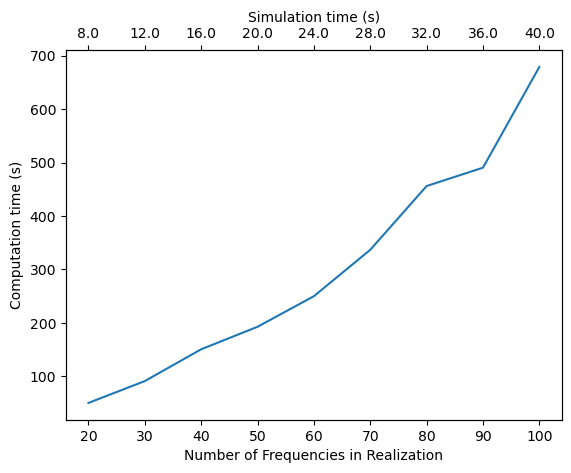

In [128]:
# Plot the computation time vs. number of frequencies

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(nfreqs,runtime)
ax1.set_xlabel('Number of Frequencies in Realization')
ax1.set_ylabel('Computation time (s)')

# also plot total time
tperreal = 1/.02

def tick_function(X):
    V = [(1/(fend/nfreq)) for nfreq in X]
    print(V)
    return ["%.1f" % z for z in V]

ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax1.get_xticks()))
ax2.set_xlabel('Simulation time (s)')

Text(0, 0.5, 'Total computation time needed (20 min)')

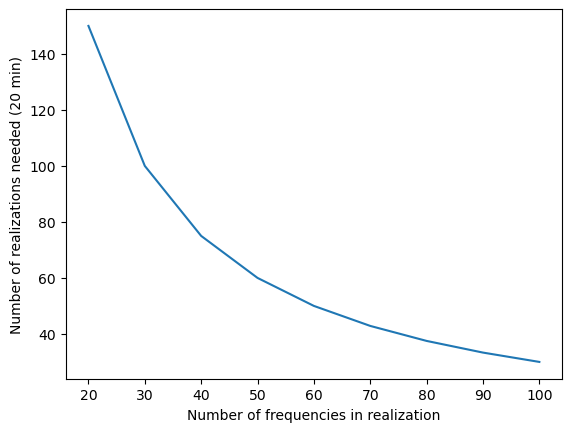

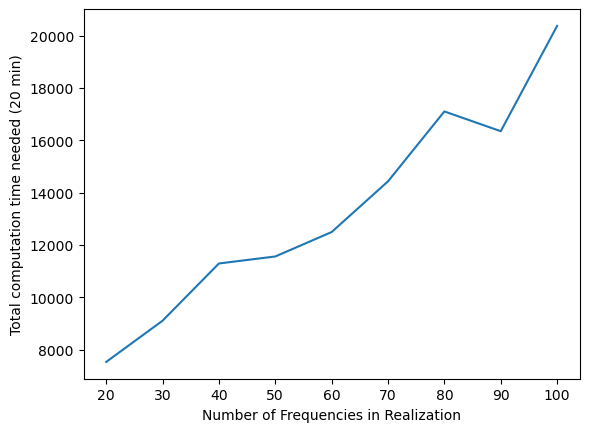

In [129]:
# plot total simulation time for each number of frequencies

minutes_needed = 20
sim_times = [(1/(fend/nfreq)) for nfreq in nfreqs]

nrealizations_needed = [minutes_needed*60/sim_time for sim_time in sim_times]

#print(nrealizations_needed.type())
total_times = [a*b for a, b in zip(nrealizations_needed,runtime)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(nfreqs,nrealizations_needed)
ax1.set_xlabel('Number of frequencies in realization')
ax1.set_ylabel('Number of realizations needed (20 min)')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(nfreqs,total_times)
ax1.set_xlabel('Number of Frequencies in Realization')
ax1.set_ylabel('Total computation time needed (20 min)')

In [39]:
# record the max absorbable power for each wave 

Pmaxs = []
nfreqs = np.linspace(20,100,9)
fend = 2.5
nrealizations = 1

Hs = .4
Tp = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

for nfreq in nfreqs:
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)

    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)
    
    print(f'nfreq: {nfreq}')
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

    print(f'Max Theoretical Power: {P_ub}')

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 20.0
Max Theoretical Power: -5628.140695694517


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel 

nfreq: 30.0
Max Theoretical Power: -13876.616666190723
('Heave', 'Heave')


nfreq: 40.0
Max Theoretical Power: -11250.792923914052


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


nfreq: 50.0
Max Theoretical Power: -11835.949280178249


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.57e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.87e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.67e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.58e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.97e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 60.0
Max Theoretical Power: -11758.238126044165


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.99e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.36e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 70.0
Max Theoretical Power: -11748.564060848348


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.66e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.56e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.46e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.36e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.26e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.92e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.84e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.77e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.63e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.56e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 80.0
Max Theoretical Power: -11760.745925925821


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.20e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.80e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.70e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.60e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.41e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.02e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=5.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.41e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.33e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.24e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.16e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.08e-01.
This warning appears because the largest panel 

('Heave', 'Heave')


nfreq: 90.0
Max Theoretical Power: -11755.283142009781


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.72e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=3.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.55e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=2.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.


('Heave', 'Heave')


nfreq: 100.0
Max Theoretical Power: -11756.76792011349


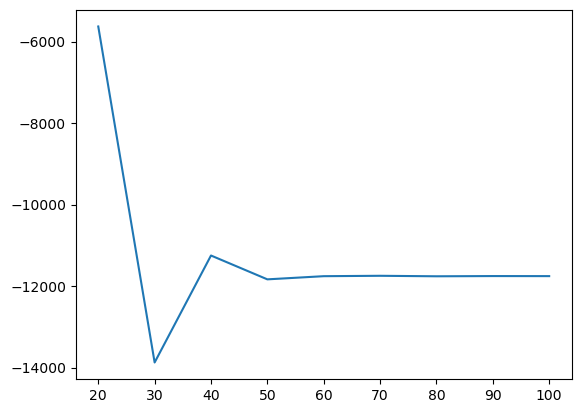

In [40]:
plt.figure()
plt.plot(nfreqs, Pmaxs)